# Start notebook 

In [1]:
# load libraries
import statsmodels.stats.multicomp
from statsmodels.formula.api import ols
import statsmodels.api as sm
import researchpy as rp
import statsFuncs.mean_confidence_interval as ms
import plotFuncs
import scipy
from scipy import stats as stats
from scipy import stats as cp
import os
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
import glob as glob
from natsort import natsorted
sns.set(color_codes=True)
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

# stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import scikit_posthocs as sp

# magic functions
%load_ext autoreload
%autoreload 2
%matplotlib inline

# create dummy class for struct-like dataframes


class structtype():
    pass


matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams.update({'axes.labelsize': 16.0})

# Paths 

In [2]:
analysispath = os.getcwd()
mainpath = analysispath + '/../'
designpath = mainpath + '/design'
resultspath = mainpath + '/results'
stimpath = mainpath + '/stim'
practicestimpath = mainpath + '/practice'
results_csv = mainpath + '/results_csv'
analysispath = mainpath + '/analysis'
design_csv = mainpath + '/design_csv'

# Load data 

In [3]:
allsubjects = pd.read_csv('allsubjects_perifovmooney_ecc_post.csv', index_col=0)

# Separate data by upright or inverted 

In [4]:
upright_data = allsubjects[allsubjects['COND'] == 'upright']
inverted_data = allsubjects[allsubjects['COND'] == 'inverted']


/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Holistic 

## absolute eccentricity 

In [5]:
numLocs = len(allsubjects.ECC_PLOT_ABS.unique())
numCategories = len(allsubjects.MOONEYCATEGORY.unique())
numSubs  = len(allsubjects.SUBINIT.unique())
accPerSubLocs = pd.DataFrame()

categorynames = list(allsubjects.MOONEYCATEGORY.unique())
locationnames = list(allsubjects.ECC_PLOT_ABS.unique())
subinitnames = list(allsubjects.SUBINIT.unique())

row = 0
for subject in subinitnames:
    # index by subject
    subdata = allsubjects[allsubjects['SUBINIT'] == subject]
    
    for location in locationnames:
        # index by location
        locationdata = subdata[subdata['ECC_PLOT_ABS'] == location]
        
        for category in categorynames:
            # index by category
                
            categorydata = locationdata[locationdata['MOONEYCATEGORY'] == category]

            # index the datapoints from each locations
            indexed_upright = categorydata[categorydata['COND'] == 'upright']

            indexed_inverted = categorydata[categorydata['COND'] == 'inverted']
            

            m_upright, lower_upright, upper_upright = ms.mean_confidence_interval(
                indexed_upright.loc[:, 'ACCURACY'])
            m_inverted, lower_inverted, upper_inverted = ms.mean_confidence_interval(
                indexed_inverted.loc[:, 'ACCURACY'])

            accPerSubLocs.loc[row, 'SUBINIT'] = subject
            accPerSubLocs.loc[row, 'ECC_PLOT_ABS'] = location
            accPerSubLocs.loc[row, 'MOONEYCATEGORY'] = category
            accPerSubLocs.loc[row, 'MEAN_UPRIGHT'] = m_upright
            accPerSubLocs.loc[row, 'CI_LOWER_UPRIGHT'] = lower_upright
            accPerSubLocs.loc[row, 'CI_UPPER_UPRIGHT'] = upper_upright

            accPerSubLocs.loc[row, 'MEAN_INVERTED'] = m_inverted
            accPerSubLocs.loc[row, 'CI_LOWER_INVERTED'] = lower_inverted
            accPerSubLocs.loc[row, 'CI_UPPER_INVERTED'] = upper_inverted

            accPerSubLocs.loc[row, 'HOLISTIC'] = accPerSubLocs.loc[row,
                                                              'MEAN_UPRIGHT'] - accPerSubLocs.loc[row, 'MEAN_INVERTED']
            row = row + 1

In [6]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('HOLISTIC ~ C(MOONEYCATEGORY)*C(ECC_PLOT_ABS)', accPerSubLocs).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')
    
    
print(rp.summary_cont(accPerSubLocs.groupby(['MOONEYCATEGORY', 'ECC_PLOT_ABS']))['HOLISTIC'])
print(model.summary())


# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
print(res)
print('\n\nThe interaction is not significant p = 0.1')

mc = statsmodels.stats.multicomp.MultiComparison(accPerSubLocs['HOLISTIC'], accPerSubLocs['ECC_PLOT_ABS'])
mc_results = mc.tukeyhsd()
print(mc_results)

Overall model F( 13, 336) =  13.352, p =  0.0000
The overall model is significant


                              N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY ECC_PLOT_ABS                                                 
high holistic  0.0           25  0.2560  0.1342  0.0268     0.2006    0.3114
               1.0           25  0.2360  0.1372  0.0274     0.1794    0.2926
               2.0           25  0.2264  0.1005  0.0201     0.1849    0.2679
               3.0           25  0.2160  0.1047  0.0209     0.1728    0.2592
               4.0           25  0.2144  0.1458  0.0292     0.1542    0.2746
               5.0           25  0.1824  0.1440  0.0288     0.1229    0.2419
               6.0           25  0.1816  0.1176  0.0235     0.1331    0.2301
low holistic   0.0           25  0.0544  0.0662  0.0132     0.0271    0.0817
               1.0           25  0.0528  0.0781  0.0156     0.0206    0.0850
               2.0           25  0.0664  0.0748  0.0150     0.0355   

### Repeated measures

In [7]:
aovrm2way = AnovaRM(accPerSubLocs, 'HOLISTIC', 'SUBINIT', within=['ECC_PLOT_ABS', 'MOONEYCATEGORY'])
res2way = aovrm2way.fit()

print(res2way)

                          Anova
                            F Value Num DF  Den DF  Pr > F
----------------------------------------------------------
ECC_PLOT_ABS                 0.3024 6.0000 144.0000 0.9348
MOONEYCATEGORY              68.5187 1.0000  24.0000 0.0000
ECC_PLOT_ABS:MOONEYCATEGORY  2.9421 6.0000 144.0000 0.0097



In [8]:
aov = pg.rm_anova(data=accPerSubLocs, dv='HOLISTIC', within=['MOONEYCATEGORY', 'ECC_PLOT_ABS'], subject='SUBINIT', detailed=True, effsize='n2')
pg.print_table(aov)
x = pg.pairwise_ttests(data=accPerSubLocs, dv='HOLISTIC', within=[ 'MOONEYCATEGORY', 'ECC_PLOT_ABS'], subject='SUBINIT', marginal=True, padjust='holm', effsize= 'eta-square')
x[x['Contrast'] == 'MOONEYCATEGORY * ECC_PLOT_ABS'].to_csv('ttests_abseccs.csv')


ANOVA SUMMARY

Source                            SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr     n2    eps
-----------------------------  -----  -------  -------  -----  ------  -------  -----------  -----  -----
MOONEYCATEGORY                 1.780        1       24  1.780  68.519    0.000        0.000  0.364  1.000
ECC_PLOT_ABS                   0.014        6      144  0.002   0.302    0.935        0.915  0.003  0.861
MOONEYCATEGORY * ECC_PLOT_ABS  0.145        6      144  0.024   2.942    0.010        0.013  0.030  0.882



In [9]:
x

,Contrast,MOONEYCATEGORY,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,MOONEYCATEGORY,-,high holistic,low holistic,True,True,8.277602,24.0,two-sided,1.716419e-08,NaN,NaN,7.778e+05,0.544672
1,ECC_PLOT_ABS,-,0.0,1.0,True,True,0.578963,24.0,two-sided,5.680088e-01,1.0,holm,0.246,0.003774
2,ECC_PLOT_ABS,-,0.0,2.0,True,True,0.664383,24.0,two-sided,5.127787e-01,1.0,holm,0.258,0.003502
3,ECC_PLOT_ABS,-,0.0,3.0,True,True,0.268110,24.0,two-sided,7.909058e-01,1.0,holm,0.218,0.000541
4,ECC_PLOT_ABS,-,0.0,4.0,True,True,0.749069,24.0,two-sided,4.610950e-01,1.0,holm,0.272,0.009491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,MOONEYCATEGORY * ECC_PLOT_ABS,low holistic,3.0,5.0,True,True,-0.035426,24.0,two-sided,9.720334e-01,1.0,holm,0.211,0.000023
60,MOONEYCATEGORY * ECC_PLOT_ABS,low holistic,3.0,6.0,True,True,-0.571213,24.0,two-sided,5.731662e-01,1.0,holm,0.245,0.004994
61,MOONEYCATEGORY * ECC_PLOT_ABS,low holistic,4.0,5.0,True,True,-1.128187,24.0,two-sided,2.703931e-01,1.0,holm,0.373,0.018627
62,MOONEYCATEGORY * ECC_PLOT_ABS,low holistic,4.0,6.0,True,True,-1.738787,24.0,two-sided,9.488624e-02,1.0,holm,0.781,0.041449


## all eccentricites 

In [10]:
numLocs = len(allsubjects.ECC_PLOT.unique())
numCategories = len(allsubjects.MOONEYCATEGORY.unique())
numSubs  = len(allsubjects.SUBINIT.unique())
accPerSubLocs = pd.DataFrame()

categorynames = list(allsubjects.MOONEYCATEGORY.unique())
locationnames = list(allsubjects.ECC_PLOT.unique())
subinitnames = list(allsubjects.SUBINIT.unique())

row = 0
for subject in subinitnames:
    # index by subject
    subdata = allsubjects[allsubjects['SUBINIT'] == subject]
    
    for location in locationnames:
        # index by location
        locationdata = subdata[subdata['ECC_PLOT'] == location]
        
        for category in categorynames:
            # index by category
                
            categorydata = locationdata[locationdata['MOONEYCATEGORY'] == category]

            # index the datapoints from each locations
            indexed_upright = categorydata[categorydata['COND'] == 'upright']

            indexed_inverted = categorydata[categorydata['COND'] == 'inverted']
            

            m_upright, lower_upright, upper_upright = ms.mean_confidence_interval(
                indexed_upright.loc[:, 'ACCURACY'])
            m_inverted, lower_inverted, upper_inverted = ms.mean_confidence_interval(
                indexed_inverted.loc[:, 'ACCURACY'])

            accPerSubLocs.loc[row, 'SUBINIT'] = subject
            accPerSubLocs.loc[row, 'ECC_PLOT'] = location
            accPerSubLocs.loc[row, 'MOONEYCATEGORY'] = category
            accPerSubLocs.loc[row, 'MEAN_UPRIGHT'] = m_upright
            accPerSubLocs.loc[row, 'CI_LOWER_UPRIGHT'] = lower_upright
            accPerSubLocs.loc[row, 'CI_UPPER_UPRIGHT'] = upper_upright

            accPerSubLocs.loc[row, 'MEAN_INVERTED'] = m_inverted
            accPerSubLocs.loc[row, 'CI_LOWER_INVERTED'] = lower_inverted
            accPerSubLocs.loc[row, 'CI_UPPER_INVERTED'] = upper_inverted

            accPerSubLocs.loc[row, 'HOLISTIC'] = accPerSubLocs.loc[row,
                                                              'MEAN_UPRIGHT'] - accPerSubLocs.loc[row, 'MEAN_INVERTED']
            row = row + 1

In [11]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('HOLISTIC ~ C(MOONEYCATEGORY)*C(ECC_PLOT)', accPerSubLocs).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')
    
    
print(rp.summary_cont(accPerSubLocs.groupby(['MOONEYCATEGORY', 'ECC_PLOT']))['HOLISTIC'])
print(model.summary())


# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
print(res)
print('\n\nThe interaction is not significant p = 0.1')

mc = statsmodels.stats.multicomp.MultiComparison(accPerSubLocs['HOLISTIC'], accPerSubLocs['ECC_PLOT'])
mc_results = mc.tukeyhsd()
print(mc_results)

Overall model F( 25, 624) =  7.923, p =  0.0000
The overall model is significant


                          N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY ECC_PLOT                                                 
high holistic  -6.0      25  0.1872  0.1279  0.0256     0.1344    0.2400
               -5.0      25  0.2064  0.1836  0.0367     0.1306    0.2822
               -4.0      25  0.2064  0.1910  0.0382     0.1275    0.2853
               -3.0      25  0.2240  0.1249  0.0250     0.1724    0.2756
               -2.0      25  0.2544  0.1306  0.0261     0.2005    0.3083
               -1.0      25  0.2320  0.1732  0.0346     0.1605    0.3035
                0.0      25  0.2560  0.1342  0.0268     0.2006    0.3114
                1.0      25  0.2400  0.1804  0.0361     0.1655    0.3145
                2.0      25  0.1984  0.1319  0.0264     0.1440    0.2528
                3.0      25  0.2080  0.1545  0.0309     0.1442    0.2718
                4.0      25  0.2224  0.16

In [12]:
aovrm2way = AnovaRM(accPerSubLocs, 'HOLISTIC', 'SUBINIT', within=['ECC_PLOT', 'MOONEYCATEGORY'])
res2way = aovrm2way.fit()

print(res2way)

                         Anova
                        F Value  Num DF  Den DF  Pr > F
-------------------------------------------------------
ECC_PLOT                 0.9038 12.0000 288.0000 0.5435
MOONEYCATEGORY          59.9034  1.0000  24.0000 0.0000
ECC_PLOT:MOONEYCATEGORY  1.7191 12.0000 288.0000 0.0622



In [13]:
aov = pg.rm_anova(data=accPerSubLocs, dv='HOLISTIC', within=['MOONEYCATEGORY', 'ECC_PLOT'], subject='SUBINIT', detailed=True, effsize='n2')
pg.print_table(aov)
x = pg.pairwise_ttests(data=accPerSubLocs, dv='HOLISTIC', within=[ 'MOONEYCATEGORY', 'ECC_PLOT'], subject='SUBINIT', marginal=True, padjust='holm', effsize= 'eta-square')


ANOVA SUMMARY

Source                        SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr     n2    eps
-------------------------  -----  -------  -------  -----  ------  -------  -----------  -----  -----
MOONEYCATEGORY             3.099        1       24  3.099  59.903    0.000        0.000  0.232  1.000
ECC_PLOT                   0.162       12      288  0.013   0.904    0.544        0.517  0.012  0.695
MOONEYCATEGORY * ECC_PLOT  0.305       12      288  0.025   1.719    0.062        0.091  0.023  0.705



In [14]:
x[x['Contrast'] == 'MOONEYCATEGORY * ECC_PLOT'].to_csv('ttests_alleccs.csv')

In [15]:
pg.print_table(x)


POST HOC TESTS

Contrast                   MOONEYCATEGORY    A              B             Paired    Parametric         T     dof  Tail         p-unc    p-corr  p-adjust          BF10    eta-square
-------------------------  ----------------  -------------  ------------  --------  ------------  ------  ------  ---------  -------  --------  ----------  ----------  ------------
MOONEYCATEGORY             -                 high holistic  low holistic  True      True           7.740  24.000  two-sided    0.000   nan      nan         256600.000         0.526
ECC_PLOT                   -                 -6.0           -5.0          True      True          -0.905  24.000  two-sided    0.375     1.000  holm             0.305         0.018
ECC_PLOT                   -                 -6.0           -4.0          True      True          -0.742  24.000  two-sided    0.465     1.000  holm             0.271         0.010
ECC_PLOT                   -                 -6.0           -3.0          True

## Left vs Right 

In [16]:
numLocs = len(allsubjects.LOC.unique())
numCategories = len(allsubjects.MOONEYCATEGORY.unique())
numSubs  = len(allsubjects.SUBINIT.unique())
accPerSubLocs = pd.DataFrame()

categorynames = list(allsubjects.MOONEYCATEGORY.unique())
locationnames = list(allsubjects.LOC.unique())
subinitnames = list(allsubjects.SUBINIT.unique())

row = 0
for subject in subinitnames:
    # index by subject
    subdata = allsubjects[allsubjects['SUBINIT'] == subject]
    
    for location in locationnames:
        # index by location
        locationdata = subdata[subdata['LOC'] == location]
        
        for category in categorynames:
            # index by category
                
            categorydata = locationdata[locationdata['MOONEYCATEGORY'] == category]

            # index the datapoints from each locations
            indexed_upright = categorydata[categorydata['COND'] == 'upright']

            indexed_inverted = categorydata[categorydata['COND'] == 'inverted']
            

            m_upright, lower_upright, upper_upright = ms.mean_confidence_interval(
                indexed_upright.loc[:, 'ACCURACY'])
            m_inverted, lower_inverted, upper_inverted = ms.mean_confidence_interval(
                indexed_inverted.loc[:, 'ACCURACY'])

            accPerSubLocs.loc[row, 'SUBINIT'] = subject
            accPerSubLocs.loc[row, 'LOC'] = location
            accPerSubLocs.loc[row, 'MOONEYCATEGORY'] = category
            accPerSubLocs.loc[row, 'MEAN_UPRIGHT'] = m_upright
            accPerSubLocs.loc[row, 'CI_LOWER_UPRIGHT'] = lower_upright
            accPerSubLocs.loc[row, 'CI_UPPER_UPRIGHT'] = upper_upright

            accPerSubLocs.loc[row, 'MEAN_INVERTED'] = m_inverted
            accPerSubLocs.loc[row, 'CI_LOWER_INVERTED'] = lower_inverted
            accPerSubLocs.loc[row, 'CI_UPPER_INVERTED'] = upper_inverted

            accPerSubLocs.loc[row, 'HOLISTIC'] = accPerSubLocs.loc[row,
                                                              'MEAN_UPRIGHT'] - accPerSubLocs.loc[row, 'MEAN_INVERTED']
            row = row + 1

In [17]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('HOLISTIC ~ C(MOONEYCATEGORY)*C(LOC)', accPerSubLocs).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')
    
    
print(rp.summary_cont(accPerSubLocs.groupby(['MOONEYCATEGORY', 'LOC']))['HOLISTIC'])
print(model.summary())


# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
print(res)
print('\n\nThe interaction is not significant p = 0.1')

mc = statsmodels.stats.multicomp.MultiComparison(accPerSubLocs['HOLISTIC'], accPerSubLocs['LOC'])
mc_results = mc.tukeyhsd()
print(mc_results)

Overall model F( 5, 144) =  25.381, p =  0.0000
The overall model is significant


                       N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY LOC                                                   
high holistic  fovea  25  0.2560  0.1342  0.0268     0.2006    0.3114
               left   25  0.2184  0.1020  0.0204     0.1763    0.2605
               right  25  0.2005  0.0863  0.0173     0.1649    0.2361
low holistic   fovea  25  0.0544  0.0662  0.0132     0.0271    0.0817
               left   25  0.0872  0.0526  0.0105     0.0655    0.1089
               right  25  0.0661  0.0505  0.0101     0.0453    0.0870
                            OLS Regression Results                            
Dep. Variable:               HOLISTIC   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     25.38
Date:                Thu, 04 Nov 2021   P

### Repeated measures 

In [18]:
aovrm2way = AnovaRM(accPerSubLocs, 'HOLISTIC', 'SUBINIT', within=['LOC', 'MOONEYCATEGORY'])
res2way = aovrm2way.fit()

print(res2way)

                     Anova
                   F Value Num DF  Den DF Pr > F
------------------------------------------------
LOC                 1.9163 2.0000 48.0000 0.1582
MOONEYCATEGORY     87.2074 1.0000 24.0000 0.0000
LOC:MOONEYCATEGORY  3.7279 2.0000 48.0000 0.0313



In [19]:
import pingouin as pg
aov = pg.rm_anova(data=accPerSubLocs, dv='HOLISTIC', within=['LOC', 'MOONEYCATEGORY'], subject='SUBINIT', detailed=True, effsize='n2')
pg.print_table(aov)


ANOVA SUMMARY

Source                   SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr     n2    eps
--------------------  -----  -------  -------  -----  ------  -------  -----------  -----  -----
LOC                   0.014        2       48  0.007   1.916    0.158        0.168  0.009  0.791
MOONEYCATEGORY        0.909        1       24  0.909  87.207    0.000        0.000  0.552  1.000
LOC * MOONEYCATEGORY  0.040        2       48  0.020   3.728    0.031        0.038  0.024  0.868



In [20]:
pg.pairwise_ttests(data=accPerSubLocs, dv='HOLISTIC', within=[ 'MOONEYCATEGORY', 'LOC'], subject='SUBINIT', marginal=True, padjust='holm', effsize= 'eta-square')

,Contrast,MOONEYCATEGORY,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,MOONEYCATEGORY,-,high holistic,low holistic,True,True,9.338490,24.0,two-sided,1.838834e-09,NaN,NaN,6.295e+06,0.569997
1,LOC,-,fovea,left,True,True,0.163264,24.0,two-sided,8.716775e-01,0.871678,holm,0.213,0.000313
2,LOC,-,fovea,right,True,True,1.774901,24.0,two-sided,8.860032e-02,0.177201,holm,0.823,0.023867
3,LOC,-,left,right,True,True,2.144567,24.0,two-sided,4.232098e-02,0.126963,holm,1.462,0.033009
4,MOONEYCATEGORY * LOC,high holistic,fovea,left,True,True,1.555923,24.0,two-sided,1.328160e-01,0.486420,holm,0.609,0.024279
5,MOONEYCATEGORY * LOC,high holistic,fovea,right,True,True,2.335347,24.0,two-sided,2.821400e-02,0.169284,holm,2.026,0.057018
6,MOONEYCATEGORY * LOC,high holistic,left,right,True,True,1.091465,24.0,two-sided,2.859049e-01,0.571810,holm,0.36,0.008863
7,MOONEYCATEGORY * LOC,low holistic,fovea,left,True,True,-1.725548,24.0,two-sided,9.728404e-02,0.486420,holm,0.767,0.069966
8,MOONEYCATEGORY * LOC,low holistic,fovea,right,True,True,-0.758489,24.0,two-sided,4.555428e-01,0.571810,holm,0.274,0.009833
9,MOONEYCATEGORY * LOC,low holistic,left,right,True,True,1.688544,24.0,two-sided,1.042601e-01,0.486420,holm,0.728,0.040083


# Model with absolute eccentricity 

## Model holistic 

### ANOVA 

## Model upright 

### ANOVA

ECCENTRICITY can be 0, 2, 4, 6, 8, 10 or 12 where 0 represents the fovea

In [21]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('ACCURACY ~ C(ECCENTRICITY)*C(MOONEYCATEGORY)', upright_data).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')

Overall model F( 13, 16236) =  45.080, p =  0.0000
The overall model is significant


In [22]:
rp.summary_cont(upright_data.groupby(['MOONEYCATEGORY', 'ECCENTRICITY']))['ACCURACY']

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY ECCENTRICITY                                                   
high holistic  0              625  0.8512  0.3562  0.0142     0.8232    0.8792
               2             1250  0.8304  0.3754  0.0106     0.8096    0.8512
               4             1250  0.7888  0.4083  0.0115     0.7661    0.8115
               6             1250  0.7736  0.4187  0.0118     0.7504    0.7968
               8             1250  0.7608  0.4268  0.0121     0.7371    0.7845
               10            1250  0.7216  0.4484  0.0127     0.6967    0.7465
               12            1250  0.6976  0.4595  0.0130     0.6721    0.7231
low holistic   0              625  0.9184  0.2740  0.0110     0.8969    0.9399
               2             1250  0.9032  0.2958  0.0084     0.8868    0.9196
               4             1250  0.8976  0.3033  0.0086     0.8808    0.9144
               6             1250  0.8936  0.3085  0.0087     0.8765    0.9107
               8             1250  0.8888  0.3145  0.0089     0.8713    0.9063
               10            1250  0.8656  0.3412  0.0097     0.8467    0.8845
               12            1250  0.8776  0.3279  0.0093     0.8594    0.8958

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ACCURACY   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     45.08
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          1.05e-114
Time:                        15:15:42   Log-Likelihood:                -6876.1
No. Observations:               16250   AIC:                         1.378e+04
Df Residuals:                   16236   BIC:                         1.389e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   0.8512      0.015     57.577      0.000       0.822       0.880
C(ECCENTRICITY)[T.2]                                       -0.0208      0.018     -1.149      0.251      -0.056       0.015
C(ECCENTRICITY)[T.4]                                       -0.0624      0.018     -3.446      0.001      -0.098      -0.027
C(ECCENTRICITY)[T.6]                                       -0.0776      0.018     -4.286      0.000      -0.113      -0.042
C(ECCENTRICITY)[T.8]                                       -0.0904      0.018     -4.993      0.000      -0.126      -0.055
C(ECCENTRICITY)[T.10]                                      -0.1296      0.018     -7.158      0.000      -0.165      -0.094
C(ECCENTRICITY)[T.12]                                      -0.1536      0.018     -8.483      0.000      -0.189      -0.118
C(MOONEYCATEGORY)[T.low holistic]                           0.0672      0.021      3.214      0.001       0.026       0.108
C(ECCENTRICITY)[T.2]:C(MOONEYCATEGORY)[T.low holistic]      0.0056      0.026      0.219      0.827      -0.045       0.056
C(ECCENTRICITY)[T.4]:C(MOONEYCATEGORY)[T.low holistic]      0.0416      0.026      1.625      0.104      -0.009       0.092
C(ECCENTRICITY)[T.6]:C(MOONEYCATEGORY)[T.low holistic]      0.0528      0.026      2.062      0.039       0.003       0.103
C(ECCENTRICITY)[T.8]:C(MOONEYCATEGORY)[T.low holistic]      0.0608      0.026      2.374      0.018       0.011       0.111
C(ECCENTRICITY)[T.10]:C(MOONEYCATEGORY)[T.low holistic]     0.0768      0.026      2.999      0.003       0.027       0.127
C(ECCENTRICITY)[T.12]:C(MOONEYCATEGORY)[T.low holistic]     0.1128      0.026      4.405      0.000       0.063       0.163
==============================================================================
Omnibus:                     4176.679   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8189.417
Skew:                          -1.663   Prob(JB):                         0.00
Kurtosis:                       4.019   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
print('\n\nThe interaction is not significant p = 0.1')
res




The interaction is not significant p = 0.1


,sum_sq,df,F,PR(>F)
C(ECCENTRICITY),15.478338,6.0,18.885800,4.947660e-22
C(MOONEYCATEGORY),59.584985,1.0,436.213533,1.301375e-95
C(ECCENTRICITY):C(MOONEYCATEGORY),4.987015,6.0,6.084876,2.230638e-06
Residual,2217.771200,16236.0,NaN,NaN


In [25]:
print('We remove the interaction term because it is not significant')
# Fits the model
model2 = ols('ACCURACY ~ C(ECCENTRICITY)+ C(MOONEYCATEGORY)', upright_data).fit()

print(f"Overall model F({model2.df_model: .0f},{model2.df_resid: .0f}) = {model2.fvalue: .3f}, p = {model2.f_pvalue: .4f}")

We remove the interaction term because it is not significant
Overall model F( 7, 16242) =  78.357, p =  0.0000


In [26]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ACCURACY   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     78.36
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          2.54e-112
Time:                        15:15:42   Log-Likelihood:                -6894.3
No. Observations:               16250   AIC:                         1.380e+04
Df Residuals:                   16242   BIC:                         1.387e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.8242      0.011     75.909      0.000       0.803       0.846
C(ECCENTRICITY)[T.2]                 -0.0180      0.013     -1.405      0.160      -0.043       0.007
C(ECCENTRICITY)[T.4]                 -0.0416      0.013     -3.246      0.001      -0.067      -0.016
C(ECCENTRICITY)[T.6]                 -0.0512      0.013     -3.995      0.000      -0.076      -0.026
C(ECCENTRICITY)[T.8]                 -0.0600      0.013     -4.682      0.000      -0.085      -0.035
C(ECCENTRICITY)[T.10]                -0.0912      0.013     -7.117      0.000      -0.116      -0.066
C(ECCENTRICITY)[T.12]                -0.0972      0.013     -7.585      0.000      -0.122      -0.072
C(MOONEYCATEGORY)[T.low holistic]     0.1211      0.006     20.866      0.000       0.110       0.132
==============================================================================
Omnibus:                     4175.865   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8187.285
Skew:                          -1.665   Prob(JB):                         0.00
Kurtosis:                       3.999   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# Creates the ANOVA table
res2 = sm.stats.anova_lm(model2, typ= 2)
res2

,sum_sq,df,F,PR(>F)
C(ECCENTRICITY),15.478338,6.0,18.850391,5.477658e-22
C(MOONEYCATEGORY),59.584985,1.0,435.395678,1.937741e-95
Residual,2222.758215,16242.0,NaN,NaN


In [28]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(res2)

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(ECCENTRICITY),15.478338,2.579723,6.0,18.850391,5.477658e-22,0.006736,0.006378
C(MOONEYCATEGORY),59.584985,59.584985,1.0,435.395678,1.937741e-95,0.025931,0.025870
Residual,2222.758215,0.136852,16242.0,NaN,NaN,NaN,NaN


### Post-hoc testing 

In [29]:
mc = statsmodels.stats.multicomp.MultiComparison(upright_data['ACCURACY'], upright_data['ECCENTRICITY'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      2   -0.018 0.7844 -0.0563  0.0203  False
     0      4  -0.0416  0.023 -0.0799 -0.0033   True
     0      6  -0.0512 0.0016 -0.0895 -0.0129   True
     0      8    -0.06  0.001 -0.0983 -0.0217   True
     0     10  -0.0912  0.001 -0.1295 -0.0529   True
     0     12  -0.0972  0.001 -0.1355 -0.0589   True
     2      4  -0.0236 0.2815 -0.0549  0.0077  False
     2      6  -0.0332 0.0289 -0.0645 -0.0019   True
     2      8   -0.042 0.0015 -0.0733 -0.0107   True
     2     10  -0.0732  0.001 -0.1045 -0.0419   True
     2     12  -0.0792  0.001 -0.1105 -0.0479   True
     4      6  -0.0096    0.9 -0.0409  0.0217  False
     4      8  -0.0184  0.579 -0.0497  0.0129  False
     4     10  -0.0496  0.001 -0.0809 -0.0183   True
     4     12  -0.0556  0.001 -0.0869 -0.0243   True
     6      8  -0.0088    0.9 -0.0401  0.0225 

## Model inverted 

### ANOVA 

In [30]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('ACCURACY ~ C(ECCENTRICITY)*C(MOONEYCATEGORY)', inverted_data).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')

Overall model F( 13, 16236) =  110.709, p =  0.0000
The overall model is significant


In [31]:
rp.summary_cont(inverted_data.groupby(['MOONEYCATEGORY', 'ECCENTRICITY']))['ACCURACY']

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY ECCENTRICITY                                                   
high holistic  0              625  0.5952  0.4912  0.0196     0.5566    0.6338
               2             1250  0.5944  0.4912  0.0139     0.5671    0.6217
               4             1250  0.5624  0.4963  0.0140     0.5349    0.5899
               6             1250  0.5576  0.4969  0.0141     0.5300    0.5852
               8             1250  0.5464  0.4980  0.0141     0.5188    0.5740
               10            1250  0.5392  0.4987  0.0141     0.5115    0.5669
               12            1250  0.5160  0.4999  0.0141     0.4883    0.5437
low holistic   0              625  0.8640  0.3431  0.0137     0.8371    0.8909
               2             1250  0.8504  0.3568  0.0101     0.8306    0.8702
               4             1250  0.8312  0.3747  0.0106     0.8104    0.8520
               6             1250  0.8064  0.3953  0.0112     0.7845    0.8283
               8             1250  0.8224  0.3823  0.0108     0.8012    0.8436
               10            1250  0.7776  0.4160  0.0118     0.7545    0.8007
               12            1250  0.7784  0.4155  0.0118     0.7553    0.8015

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ACCURACY   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     110.7
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          4.15e-287
Time:                        15:15:43   Log-Likelihood:                -9900.3
No. Observations:               16250   AIC:                         1.983e+04
Df Residuals:                   16236   BIC:                         1.994e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   0.5952      0.018     33.424      0.000       0.560       0.630
C(ECCENTRICITY)[T.2]                                       -0.0008      0.022     -0.037      0.971      -0.044       0.042
C(ECCENTRICITY)[T.4]                                       -0.0328      0.022     -1.504      0.133      -0.076       0.010
C(ECCENTRICITY)[T.6]                                       -0.0376      0.022     -1.724      0.085      -0.080       0.005
C(ECCENTRICITY)[T.8]                                       -0.0488      0.022     -2.238      0.025      -0.092      -0.006
C(ECCENTRICITY)[T.10]                                      -0.0560      0.022     -2.568      0.010      -0.099      -0.013
C(ECCENTRICITY)[T.12]                                      -0.0792      0.022     -3.631      0.000      -0.122      -0.036
C(MOONEYCATEGORY)[T.low holistic]                           0.2688      0.025     10.674      0.000       0.219       0.318
C(ECCENTRICITY)[T.2]:C(MOONEYCATEGORY)[T.low holistic]     -0.0128      0.031     -0.415      0.678      -0.073       0.048
C(ECCENTRICITY)[T.4]:C(MOONEYCATEGORY)[T.low holistic]  -2.411e-16      0.031  -7.82e-15      1.000      -0.060       0.060
C(ECCENTRICITY)[T.6]:C(MOONEYCATEGORY)[T.low holistic]     -0.0200      0.031     -0.648      0.517      -0.080       0.040
C(ECCENTRICITY)[T.8]:C(MOONEYCATEGORY)[T.low holistic]      0.0072      0.031      0.233      0.815      -0.053       0.068
C(ECCENTRICITY)[T.10]:C(MOONEYCATEGORY)[T.low holistic]    -0.0304      0.031     -0.986      0.324      -0.091       0.030
C(ECCENTRICITY)[T.12]:C(MOONEYCATEGORY)[T.low holistic]    -0.0064      0.031     -0.207      0.836      -0.067       0.054
==============================================================================
Omnibus:                     9892.852   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2153.041
Skew:                          -0.685   Prob(JB):                         0.00
Kurtosis:                       1.859   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
print('\n\nThe interaction is not significant p = 0.8')
res



The interaction is not significant p = 0.8


,sum_sq,df,F,PR(>F)
C(ECCENTRICITY),11.691138,6.0,9.831450,7.565930e-11
C(MOONEYCATEGORY),272.937600,1.0,1377.131378,2.076662e-289
C(ECCENTRICITY):C(MOONEYCATEGORY),0.613600,6.0,0.515996,7.966973e-01
Residual,3217.859200,16236.0,NaN,NaN


In [34]:
print('We remove the interaction term because it is not significant')
# Fits the model
model2 = ols('ACCURACY ~ C(ECCENTRICITY)+ C(MOONEYCATEGORY)', upright_data).fit()

print(f"Overall model F({model2.df_model: .0f},{model2.df_resid: .0f}) = {model2.fvalue: .3f}, p = {model2.f_pvalue: .4f}")

We remove the interaction term because it is not significant
Overall model F( 7, 16242) =  78.357, p =  0.0000


In [35]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ACCURACY   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     78.36
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          2.54e-112
Time:                        15:15:44   Log-Likelihood:                -6894.3
No. Observations:               16250   AIC:                         1.380e+04
Df Residuals:                   16242   BIC:                         1.387e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.8242      0.011     75.909      0.000       0.803       0.846
C(ECCENTRICITY)[T.2]                 -0.0180      0.013     -1.405      0.160      -0.043       0.007
C(ECCENTRICITY)[T.4]                 -0.0416      0.013     -3.246      0.001      -0.067      -0.016
C(ECCENTRICITY)[T.6]                 -0.0512      0.013     -3.995      0.000      -0.076      -0.026
C(ECCENTRICITY)[T.8]                 -0.0600      0.013     -4.682      0.000      -0.085      -0.035
C(ECCENTRICITY)[T.10]                -0.0912      0.013     -7.117      0.000      -0.116      -0.066
C(ECCENTRICITY)[T.12]                -0.0972      0.013     -7.585      0.000      -0.122      -0.072
C(MOONEYCATEGORY)[T.low holistic]     0.1211      0.006     20.866      0.000       0.110       0.132
==============================================================================
Omnibus:                     4175.865   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8187.285
Skew:                          -1.665   Prob(JB):                         0.00
Kurtosis:                       3.999   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Creates the ANOVA table
res2 = sm.stats.anova_lm(model2, typ= 2)
res2

,sum_sq,df,F,PR(>F)
C(ECCENTRICITY),15.478338,6.0,18.850391,5.477658e-22
C(MOONEYCATEGORY),59.584985,1.0,435.395678,1.937741e-95
Residual,2222.758215,16242.0,NaN,NaN


In [37]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(res2)

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(ECCENTRICITY),15.478338,2.579723,6.0,18.850391,5.477658e-22,0.006736,0.006378
C(MOONEYCATEGORY),59.584985,59.584985,1.0,435.395678,1.937741e-95,0.025931,0.025870
Residual,2222.758215,0.136852,16242.0,NaN,NaN,NaN,NaN


### Post-hoc testing 

In [38]:
mc = statsmodels.stats.multicomp.MultiComparison(inverted_data['ACCURACY'], inverted_data['ECCENTRICITY'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      2  -0.0072    0.9 -0.0546  0.0402  False
     0      4  -0.0328 0.3895 -0.0802  0.0146  False
     0      6  -0.0476 0.0479  -0.095 -0.0002   True
     0      8  -0.0452  0.073 -0.0926  0.0022  False
     0     10  -0.0712  0.001 -0.1186 -0.0238   True
     0     12  -0.0824  0.001 -0.1298  -0.035   True
     2      4  -0.0256 0.4478 -0.0643  0.0131  False
     2      6  -0.0404 0.0338 -0.0791 -0.0017   True
     2      8   -0.038 0.0579 -0.0767  0.0007  False
     2     10   -0.064  0.001 -0.1027 -0.0253   True
     2     12  -0.0752  0.001 -0.1139 -0.0365   True
     4      6  -0.0148    0.9 -0.0535  0.0239  False
     4      8  -0.0124    0.9 -0.0511  0.0263  False
     4     10  -0.0384  0.053 -0.0771  0.0003  False
     4     12  -0.0496  0.003 -0.0883 -0.0109   True
     6      8   0.0024    0.9 -0.0363  0.0411 

# Model with absolute eccentricity 

## Model upright 

### ANOVA

ECCENTRICITY can be-12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10 or 12 where 0 represents the fovea

In [39]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('ACCURACY ~ C(MOONEYCATEGORY)*C(LOC)', upright_data).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')
    
    
print(rp.summary_cont(upright_data.groupby(['MOONEYCATEGORY', 'LOC']))['ACCURACY'])
print(model.summary())


# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
print(res)
print('\n\nThe interaction is not significant p = 0.2')

Overall model F( 5, 16244) =  95.836, p =  0.0000
The overall model is significant


                         N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY LOC                                                     
high holistic  fovea   625  0.8512  0.3562  0.0142     0.8232    0.8792
               left   3750  0.7739  0.4184  0.0068     0.7605    0.7873
               right  3750  0.7504  0.4328  0.0071     0.7365    0.7643
low holistic   fovea   625  0.9184  0.2740  0.0110     0.8969    0.9399
               left   3750  0.8915  0.3111  0.0051     0.8815    0.9014
               right  3750  0.8840  0.3203  0.0052     0.8737    0.8943
                            OLS Regression Results                            
Dep. Variable:               ACCURACY   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     95.84
Date:                Th

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [40]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('ACCURACY ~ C(MOONEYCATEGORY)*C(ECC_PLOT)', upright_data).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')
    
    
print(rp.summary_cont(upright_data.groupby(['MOONEYCATEGORY', 'ECC_PLOT']))['ACCURACY'])
print(model.summary())


# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
print(res)
print('\n\nThe interaction is not significant p = 0.1')

mc = statsmodels.stats.multicomp.MultiComparison(upright_data['ACCURACY'], upright_data['ECC_PLOT'])
mc_results = mc.tukeyhsd()
print(mc_results)

Overall model F( 25, 16224) =  23.932, p =  0.0000
The overall model is significant


/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc




                           N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY ECC_PLOT                                                  
high holistic  -6.0      625  0.7216  0.4486  0.0179     0.6864    0.7568
               -5.0      625  0.7328  0.4429  0.0177     0.6980    0.7676
               -4.0      625  0.7632  0.4255  0.0170     0.7298    0.7966
               -3.0      625  0.7856  0.4107  0.0164     0.7533    0.8179
               -2.0      625  0.8032  0.3979  0.0159     0.7719    0.8345
               -1.0      625  0.8368  0.3698  0.0148     0.8077    0.8659
                0.0      625  0.8512  0.3562  0.0142     0.8232    0.8792
                1.0      625  0.8240  0.3811  0.0152     0.7941    0.8539
                2.0      625  0.7744  0.4183  0.0167     0.7415    0.8073
                3.0      625  0.7616  0.4264  0.0171     0.7281    0.7951
                4.0      625  0.7584  0.4284  0.0171     0.7247    0.7921
                5.0      625  0.7104

You can correct for homoscedasticity by selecting hc3 under heteroscedasticity-consistent inference

In [41]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('ACCURACY ~ C(MOONEYCATEGORY)*C(LOC)', upright_data).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')
    
    
print(rp.summary_cont(upright_data.groupby(['MOONEYCATEGORY', 'LOC']))['ACCURACY'])
print(model.summary())


# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2, robust = 'hc3')
print(res)
print('\n\nThe interaction is not significant p = 0.2')

Overall model F( 5, 16244) =  95.836, p =  0.0000
The overall model is significant


                         N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY LOC                                                     
high holistic  fovea   625  0.8512  0.3562  0.0142     0.8232    0.8792
               left   3750  0.7739  0.4184  0.0068     0.7605    0.7873
               right  3750  0.7504  0.4328  0.0071     0.7365    0.7643
low holistic   fovea   625  0.9184  0.2740  0.0110     0.8969    0.9399
               left   3750  0.8915  0.3111  0.0051     0.8815    0.9014
               right  3750  0.8840  0.3203  0.0052     0.8737    0.8943
                            OLS Regression Results                            
Dep. Variable:               ACCURACY   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     95.84
Date:                Th

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


## Model inverted

### ANOVA 

In [42]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('ACCURACY ~C(LOC)*C(MOONEYCATEGORY)', inverted_data).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')
    
    
print(rp.summary_cont(inverted_data.groupby(['MOONEYCATEGORY', 'LOC']))['ACCURACY'])
print(model.summary())


# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
print(res)
print('\n\nThe interaction is not significant p = 0.7')

Overall model F( 5, 16244) =  277.859, p =  0.0000
The overall model is significant


                         N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY LOC                                                     
high holistic  fovea   625  0.5952  0.4912  0.0196     0.5566    0.6338
               left   3750  0.5555  0.4970  0.0081     0.5396    0.5714
               right  3750  0.5499  0.4976  0.0081     0.5339    0.5658
low holistic   fovea   625  0.8640  0.3431  0.0137     0.8371    0.8909
               left   3750  0.8043  0.3968  0.0065     0.7916    0.8170
               right  3750  0.8179  0.3860  0.0063     0.8055    0.8302
                            OLS Regression Results                            
Dep. Variable:               ACCURACY   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     277.9
Date:                T

/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [43]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('ACCURACY ~ C(MOONEYCATEGORY)*C(ECC_PLOT)', inverted_data).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
if model.f_pvalue < 0.05:
    print('The overall model is significant')
    
    
print(rp.summary_cont(inverted_data.groupby(['MOONEYCATEGORY', 'ECC_PLOT']))['ACCURACY'])
print(model.summary())


# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
print(res)
print('\n\nThe interaction is not significant p = 0.9')

mc = statsmodels.stats.multicomp.MultiComparison(inverted_data['ACCURACY'], inverted_data['ECC_PLOT'])
mc_results = mc.tukeyhsd()
print(mc_results)

Overall model F( 25, 16224) =  58.154, p =  0.0000
The overall model is significant


/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc




                           N    Mean      SD      SE  95% Conf.  Interval
MOONEYCATEGORY ECC_PLOT                                                  
high holistic  -6.0      625  0.5344  0.4992  0.0200     0.4952    0.5736
               -5.0      625  0.5264  0.4997  0.0200     0.4871    0.5657
               -4.0      625  0.5568  0.4972  0.0199     0.5177    0.5959
               -3.0      625  0.5616  0.4966  0.0199     0.5226    0.6006
               -2.0      625  0.5488  0.4980  0.0199     0.5097    0.5879
               -1.0      625  0.6048  0.4893  0.0196     0.5664    0.6432
                0.0      625  0.5952  0.4912  0.0196     0.5566    0.6338
                1.0      625  0.5840  0.4933  0.0197     0.5453    0.6227
                2.0      625  0.5760  0.4946  0.0198     0.5371    0.6149
                3.0      625  0.5536  0.4975  0.0199     0.5145    0.5927
                4.0      625  0.5360  0.4991  0.0200     0.4968    0.5752
                5.0      625  0.5520

# Repeated measures 

In [44]:
aov = pg.rm_anova(data=upright_data, dv='ACCURACY', within=['MOONEYCATEGORY', 'ECC_PLOT'], subject='SUBINIT', detailed=True, effsize='n2')
pg.print_table(aov)
pg.pairwise_ttests(data=upright_data, dv='ACCURACY', within=[ 'MOONEYCATEGORY', 'ECC_PLOT'], subject='SUBINIT', marginal=True, padjust='holm', effsize= 'eta-square')
# x[x['Contrast'] == 'MOONEYCATEGORY * ECC_PLOT_ABS'].to_csv('ttests_abseccs.csv')


ANOVA SUMMARY

Source                        SS    ddof1    ddof2     MS        F    p-unc    p-GG-corr     n2    eps
-------------------------  -----  -------  -------  -----  -------  -------  -----------  -----  -----
MOONEYCATEGORY             2.383        1       24  2.383  123.055    0.000        0.000  0.330  1.000
ECC_PLOT                   0.659       12      288  0.055    8.781    0.000        0.000  0.091  0.553
MOONEYCATEGORY * ECC_PLOT  0.227       12      288  0.019    3.241    0.000        0.003  0.031  0.572



,Contrast,MOONEYCATEGORY,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,eta-square
0,MOONEYCATEGORY,-,high holistic,low holistic,True,True,-11.093003,24.0,two-sided,6.245772e-11,NaN,NaN,1.519e+08,0.312470
1,ECC_PLOT,-,-6.0,-5.0,True,True,-0.445521,24.0,two-sided,6.599363e-01,1.000000,holm,0.231,0.001483
2,ECC_PLOT,-,-6.0,-4.0,True,True,-1.769835,24.0,two-sided,8.946013e-02,1.000000,holm,0.817,0.023278
3,ECC_PLOT,-,-6.0,-3.0,True,True,-3.493579,24.0,two-sided,1.871856e-03,0.106696,holm,20.078,0.039501
4,ECC_PLOT,-,-6.0,-2.0,True,True,-4.755564,24.0,two-sided,7.731321e-05,0.005335,holm,338.676,0.069319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,MOONEYCATEGORY * ECC_PLOT,low holistic,3.0,5.0,True,True,2.079347,624.0,two-sided,3.799324e-02,1.000000,holm,0.384,0.003078
231,MOONEYCATEGORY * ECC_PLOT,low holistic,3.0,6.0,True,True,0.566639,624.0,two-sided,5.711634e-01,1.000000,holm,0.053,0.000231
232,MOONEYCATEGORY * ECC_PLOT,low holistic,4.0,5.0,True,True,1.580596,624.0,two-sided,1.144773e-01,1.000000,holm,0.156,0.001835
233,MOONEYCATEGORY * ECC_PLOT,low holistic,4.0,6.0,True,True,0.090095,624.0,two-sided,9.282403e-01,1.000000,holm,0.045,0.000006


In [46]:
aov = pg.rm_anova(data=allsubjects, dv='ACCURACY', within=['COND', 'MOONEYCATEGORY', 'ECC_PLOT'], subject='SUBINIT', detailed=True, effsize='n2')
pg.print_table(aov)
pg.pairwise_ttests(data=allsubjects, dv='ACCURACY', within=['COND', 'MOONEYCATEGORY', 'ECC_PLOT'], subject='SUBINIT', marginal=True, padjust='holm', effsize= 'eta-square')
# x[x['Contrast'] == 'MOONEYCATEGORY * ECC_PLOT_ABS'].to_csv('ttests_abseccs.csv')

ValueError: Repeated measures ANOVA with three or more factors are not yet supported.

In [ ]:
aovrm2way = AnovaRM(allsubjects, 'ACCURACY', 'SUBINIT', within=['COND','ECC_PLOT_ABS', 'MOONEYCATEGORY'], aggregate_func='mean')
res2way = aovrm2way.fit()

print(res2way)

# Descriptive 

In [48]:
descriptives = allsubjects.groupby(['SUBINIT', 'COND', 'MOONEYCATEGORY'], as_index=False).mean()

In [49]:
stats.sem(descriptives[descriptives['COND'] == 'upright']['ACCURACY'])

0.01526104217555353

In [50]:
np.mean(descriptives[(descriptives['MOONEYCATEGORY'] == 'high holistic') & (descriptives['COND'] == 'inverted')]['ACCURACY'])

0.5559384615384615

In [51]:
stats.sem(descriptives[(descriptives['MOONEYCATEGORY'] == 'high holistic') & (descriptives['COND'] == 'inverted')]['ACCURACY'])

0.015677942142465165

In [52]:
np.mean(descriptives[(descriptives['MOONEYCATEGORY'] == 'low holistic') & (descriptives['COND'] == 'upright')]['ACCURACY'])

0.8900923076923078

In [53]:
stats.sem(descriptives[(descriptives['MOONEYCATEGORY'] == 'low holistic') & (descriptives['COND'] == 'upright')]['ACCURACY'])

0.019231401015263085

In [54]:
np.mean(descriptives[(descriptives['MOONEYCATEGORY'] == 'low holistic') & (descriptives['COND'] == 'inverted')]['ACCURACY'])

0.8151384615384617

In [55]:
stats.sem(descriptives[(descriptives['MOONEYCATEGORY'] == 'low holistic') & (descriptives['COND'] == 'inverted')]['ACCURACY'])

0.02142749436571853

In [56]:
np.mean(allsubjects[(allsubjects['MOONEYCATEGORY'] == 'high holistic') & (allsubjects['LOC'] == 'fovea') & (allsubjects['COND'] == 'upright')]['ACCURACY'])

0.8512

In [57]:
descriptives_2 = allsubjects.groupby(['SUBINIT', 'COND', 'MOONEYCATEGORY', 'LOC'], as_index=False).mean()

In [58]:
stats.sem(descriptives_2[(descriptives_2['MOONEYCATEGORY'] == 'high holistic') & (descriptives_2['LOC'] == 'fovea') & (descriptives_2['COND'] == 'upright')]['ACCURACY'])

0.02233323383062411

# Floor analysis 

## Across subject 

### Upright vs inverted

In [59]:
perMooney_means = allsubjects.groupby(['MOONEY_NAME', 'ECCENTRICITY', 'LOC', 'COND', 'MOONEYCATEGORY'], as_index=False)['ACCURACY'].mean()
perMooney_means.tail()

,MOONEY_NAME,ECCENTRICITY,LOC,COND,MOONEYCATEGORY,ACCURACY
1035,U0362.bmp,12,left,upright,low holistic,0.962963
1036,U0362.bmp,12,right,inverted,high holistic,0.512821
1037,U0362.bmp,12,right,inverted,low holistic,0.814815
1038,U0362.bmp,12,right,upright,high holistic,0.666667
1039,U0362.bmp,12,right,upright,low holistic,0.920000


In [60]:
perMooney_means_highholistic = perMooney_means[perMooney_means['MOONEYCATEGORY'] == 'high holistic']
perMooney_means_highholistic.head()

,MOONEY_NAME,ECCENTRICITY,LOC,COND,MOONEYCATEGORY,ACCURACY
0,U0006.bmp,0,fovea,inverted,high holistic,0.571429
2,U0006.bmp,0,fovea,upright,high holistic,0.848485
4,U0006.bmp,2,left,inverted,high holistic,0.500000
6,U0006.bmp,2,left,upright,high holistic,0.843750
8,U0006.bmp,2,right,inverted,high holistic,0.714286


In [61]:
perMooney_means_highholistic.ECCENTRICITY.unique()

array([ 0,  2,  4,  6,  8, 10, 12])

In [62]:
perMooney_means_highholistic['ECCLOC'] = perMooney_means_highholistic['ECCENTRICITY'].astype('str') + perMooney_means_highholistic['LOC']
perMooney_means_highholistic.head()


<ipython-input-62-a86a3136f0f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perMooney_means_highholistic['ECCLOC'] = perMooney_means_highholistic['ECCENTRICITY'].astype('str') + perMooney_means_highholistic['LOC']


,MOONEY_NAME,ECCENTRICITY,LOC,COND,MOONEYCATEGORY,ACCURACY,ECCLOC
0,U0006.bmp,0,fovea,inverted,high holistic,0.571429,0fovea
2,U0006.bmp,0,fovea,upright,high holistic,0.848485,0fovea
4,U0006.bmp,2,left,inverted,high holistic,0.500000,2left
6,U0006.bmp,2,left,upright,high holistic,0.843750,2left
8,U0006.bmp,2,right,inverted,high holistic,0.714286,2right


In [63]:
perMooney_means_highholistic['ECCLOC'] = perMooney_means_highholistic['ECCENTRICITY']
perMooney_means_highholistic.loc[perMooney_means_highholistic['LOC'] == 'left', 'ECCLOC'] = -perMooney_means_highholistic.loc[perMooney_means_highholistic['LOC'] == 'left', 'ECCENTRICITY']
# perMooney_means_highholistic.loc[perMooney_means_highholistic['LOC'] == 'right', 'ECCLOC'] = +perMooney_means_highholistic.loc[perMooney_means_highholistic['LOC'] == 'right', 'ECCENTRICITY']
# perMooney_means_highholistic.loc[perMooney_means_highholistic['LOC'] == 'right', 'ECCLOC'] = +perMooney_means_highholistic.loc[perMooney_means_highholistic['LOC'] == 'right', 'ECCENTRICITY']

<ipython-input-63-0e79633d0e9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perMooney_means_highholistic['ECCLOC'] = perMooney_means_highholistic['ECCENTRICITY']
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [64]:
perMooney_means_highholistic.head()

,MOONEY_NAME,ECCENTRICITY,LOC,COND,MOONEYCATEGORY,ACCURACY,ECCLOC
0,U0006.bmp,0,fovea,inverted,high holistic,0.571429,0
2,U0006.bmp,0,fovea,upright,high holistic,0.848485,0
4,U0006.bmp,2,left,inverted,high holistic,0.500000,-2
6,U0006.bmp,2,left,upright,high holistic,0.843750,-2
8,U0006.bmp,2,right,inverted,high holistic,0.714286,2


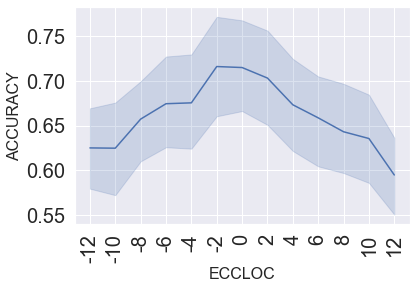

In [65]:
labels=[]
for i in range(-12, 14, 2):
    labels.append(str(i))

ax = sns.lineplot(x = 'ECCLOC', y='ACCURACY', data=perMooney_means_highholistic)
plt.xticks(range(-12, 14, 2), labels=labels, rotation=90);

<ipython-input-66-b56f767fc05e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perMooney_means_holistic['ECCLOC'] = perMooney_means_holistic['ECCENTRICITY'].copy()
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


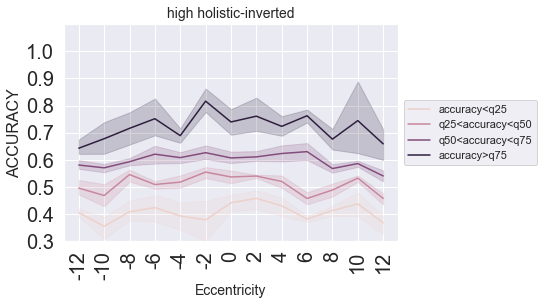

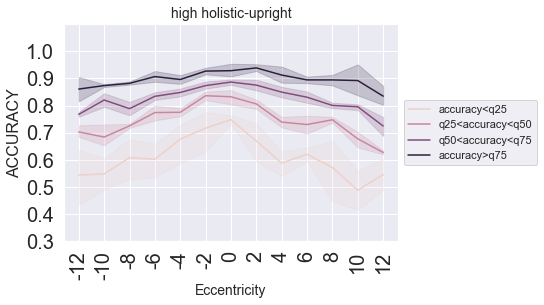

<ipython-input-66-b56f767fc05e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perMooney_means_holistic['ECCLOC'] = perMooney_means_holistic['ECCENTRICITY'].copy()
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


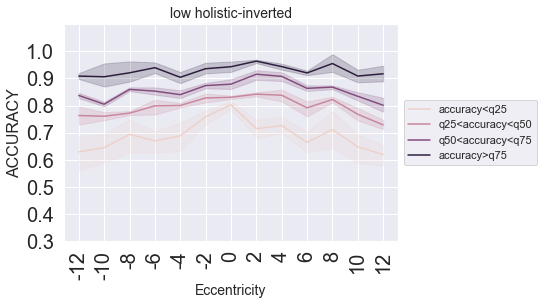

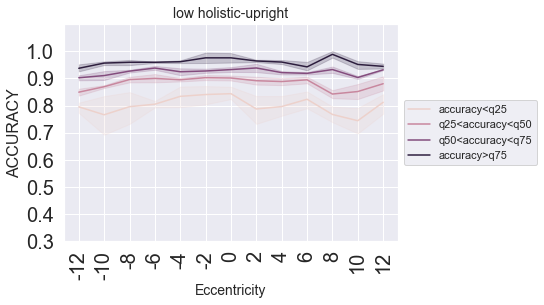

In [66]:
for holistic in perMooney_means.MOONEYCATEGORY.unique():
    
    perMooney_means_holistic = perMooney_means[perMooney_means['MOONEYCATEGORY'] == holistic]

    perMooney_means_holistic['ECCLOC'] = perMooney_means_holistic['ECCENTRICITY'].copy()
    perMooney_means_holistic.loc[perMooney_means_holistic['LOC'] == 'left', 'ECCLOC'] = -perMooney_means_holistic.loc[perMooney_means_holistic['LOC'] == 'left', 'ECCENTRICITY']
    
    for orientation in perMooney_means_holistic.COND.unique():
        perMooney_means_holistic_orientation = perMooney_means_holistic[perMooney_means_holistic['COND'] == orientation]

        labels=[]
        for i in range(-12, 14, 2):
            labels.append(str(i))

        def percentile(n):
            def percentile_(x):
                return np.percentile(x, n)
            percentile_.__name__ = 'percentile_%s' % n
            return percentile_


        quartiles_holistic = (perMooney_means_holistic_orientation.groupby(["ECCLOC"]).agg(q25= ('ACCURACY',percentile(25)), q50= ('ACCURACY',percentile(50)), q75= ('ACCURACY',percentile(75))))
#         quartiles_holistic
        
        perMooney_means_holistic_quartiles = pd.merge(perMooney_means_holistic_orientation, quartiles_holistic, how='left', on='ECCLOC')
        perMooney_means_holistic_quartiles.loc[perMooney_means_holistic_quartiles['ACCURACY'] <= perMooney_means_holistic_quartiles['q25'],'QUARTILE'] = 1
        perMooney_means_holistic_quartiles.loc[(perMooney_means_holistic_quartiles['ACCURACY'] > perMooney_means_holistic_quartiles['q25']) & (perMooney_means_holistic_quartiles['ACCURACY'] <= perMooney_means_holistic_quartiles['q50']),'QUARTILE'] = 2
        perMooney_means_holistic_quartiles.loc[(perMooney_means_holistic_quartiles['ACCURACY'] > perMooney_means_holistic_quartiles['q50']) & (perMooney_means_holistic_quartiles['ACCURACY'] <= perMooney_means_holistic_quartiles['q75']),'QUARTILE'] = 3
        perMooney_means_holistic_quartiles.loc[perMooney_means_holistic_quartiles['ACCURACY'] > perMooney_means_holistic_quartiles['q75'],'QUARTILE'] = 4

        ax = sns.lineplot(x = 'ECCLOC', y='ACCURACY', hue='QUARTILE', data=perMooney_means_holistic_quartiles)
        handles, l = ax.get_legend_handles_labels()
#         ax.legend(handles[::-1], labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'],loc='center left', bbox_to_anchor=(1, 0.5))
        ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xticks( range(-12, 14, 2), labels=labels, rotation=90); 
        plt.ylim(0.4, 1.1)
        plt.title(holistic + '-' + orientation, fontsize=14)
        plt.yticks(np.arange(0.3, 1.1, 0.1))
        plt.xlabel('Eccentricity', fontsize=14)
        plt.show()
    
        if (orientation == 'upright') & (holistic == 'high holistic'):
            perMooney_means_highholistic_quartiles_upright = perMooney_means_holistic_quartiles
        elif (orientation == 'inverted') & (holistic == 'high holistic'):
            perMooney_means_highholistic_quartiles_inverted = perMooney_means_holistic_quartiles
        elif (orientation == 'upright') & (holistic == 'low holistic'):
            perMooney_means_lowholistic_quartiles_upright = perMooney_means_holistic_quartiles
        elif (orientation == 'inverted') & (holistic == 'low holistic'):
            perMooney_means_lowholistic_quartiles_inverted = perMooney_means_holistic_quartiles

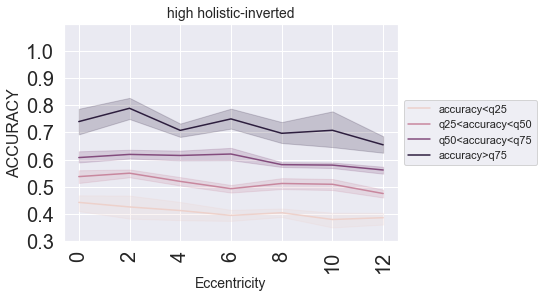

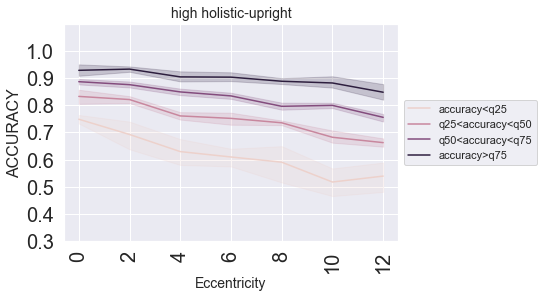

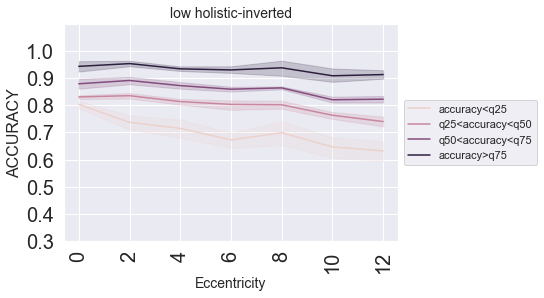

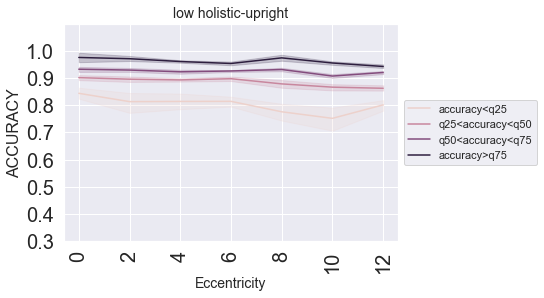

In [132]:
for holistic in perMooney_means.MOONEYCATEGORY.unique():
    
    perMooney_means_holistic = perMooney_means[perMooney_means['MOONEYCATEGORY'] == holistic]

    for orientation in perMooney_means_holistic.COND.unique():
        perMooney_means_holistic_orientation = perMooney_means_holistic[perMooney_means_holistic['COND'] == orientation]

        labels=[]
        for i in range(0, 14, 2):
            labels.append(str(i))

        def percentile(n):
            def percentile_(x):
                return np.percentile(x, n)
            percentile_.__name__ = 'percentile_%s' % n
            return percentile_


        quartiles_holistic = (perMooney_means_holistic_orientation.groupby(["ECCENTRICITY"]).agg(q25= ('ACCURACY',percentile(25)), q50= ('ACCURACY',percentile(50)), q75= ('ACCURACY',percentile(75))))
#         quartiles_holistic
        
        perMooney_means_holistic_quartiles = pd.merge(perMooney_means_holistic_orientation, quartiles_holistic, how='left', on='ECCENTRICITY')
        perMooney_means_holistic_quartiles.loc[perMooney_means_holistic_quartiles['ACCURACY'] <= perMooney_means_holistic_quartiles['q25'],'QUARTILE'] = 1
        perMooney_means_holistic_quartiles.loc[(perMooney_means_holistic_quartiles['ACCURACY'] > perMooney_means_holistic_quartiles['q25']) & (perMooney_means_holistic_quartiles['ACCURACY'] <= perMooney_means_holistic_quartiles['q50']),'QUARTILE'] = 2
        perMooney_means_holistic_quartiles.loc[(perMooney_means_holistic_quartiles['ACCURACY'] > perMooney_means_holistic_quartiles['q50']) & (perMooney_means_holistic_quartiles['ACCURACY'] <= perMooney_means_holistic_quartiles['q75']),'QUARTILE'] = 3
        perMooney_means_holistic_quartiles.loc[perMooney_means_holistic_quartiles['ACCURACY'] > perMooney_means_holistic_quartiles['q75'],'QUARTILE'] = 4

        ax = sns.lineplot(x = 'ECCENTRICITY', y='ACCURACY', hue='QUARTILE', data=perMooney_means_holistic_quartiles)
        handles, l = ax.get_legend_handles_labels()
#         ax.legend(handles[::-1], labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'],loc='center left', bbox_to_anchor=(1, 0.5))
        ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xticks( range(0, 14, 2), labels=labels, rotation=90); 
        plt.ylim(0.4, 1.1)
        plt.title(holistic + '-' + orientation, fontsize=14)
        plt.yticks(np.arange(0.3, 1.1, 0.1))
        plt.xlabel('Eccentricity', fontsize=14)
        plt.show()
    
        if (orientation == 'upright') & (holistic == 'high holistic'):
            perMooney_means_highholistic_quartiles_upright_abs = perMooney_means_holistic_quartiles
        elif (orientation == 'inverted') & (holistic == 'high holistic'):
            perMooney_means_highholistic_quartiles_inverted_abs = perMooney_means_holistic_quartiles
        elif (orientation == 'upright') & (holistic == 'low holistic'):
            perMooney_means_lowholistic_quartiles_upright_abs = perMooney_means_holistic_quartiles
        elif (orientation == 'inverted') & (holistic == 'low holistic'):
            perMooney_means_lowholistic_quartiles_inverted_abs = perMooney_means_holistic_quartiles

In [67]:
perMooney_means_lowholistic_quartiles_inverted.groupby(['ECCLOC', 'QUARTILE']).size()

ECCLOC  QUARTILE
-12     1.0         5
        2.0         5
        3.0         5
        4.0         5
-10     1.0         5
        2.0         5
        3.0         5
        4.0         5
-8      1.0         5
        2.0         5
        3.0         5
        4.0         5
-6      1.0         5
        2.0         6
        3.0         4
        4.0         5
-4      1.0         5
        2.0         5
        3.0         5
        4.0         5
-2      1.0         5
        2.0         5
        3.0         5
        4.0         5
 0      1.0         6
        2.0         4
        3.0         5
        4.0         5
 2      1.0         5
        2.0         5
        3.0         5
        4.0         5
 4      1.0         5
        2.0         5
        3.0         5
        4.0         5
 6      1.0         5
        2.0         5
        3.0         5
        4.0         5
 8      1.0         5
        2.0         5
        3.0         5
        4.0         5
 10     1.0    

In [68]:
perMooney_means_lowholistic_quartiles = pd.concat([perMooney_means_lowholistic_quartiles_upright,perMooney_means_lowholistic_quartiles_inverted])
perMooney_means_highholistic_quartiles = pd.concat([perMooney_means_highholistic_quartiles_upright,perMooney_means_highholistic_quartiles_inverted])

In [69]:
perMooney_means_lowholistic_quartiles['QUARTILE_COND'] = perMooney_means_lowholistic_quartiles['QUARTILE'].astype('str') + perMooney_means_lowholistic_quartiles['COND']

In [70]:
perMooney_means_highholistic_quartiles['QUARTILE_COND'] = perMooney_means_highholistic_quartiles['QUARTILE'].astype('str') + perMooney_means_highholistic_quartiles['COND']

### Holistic 

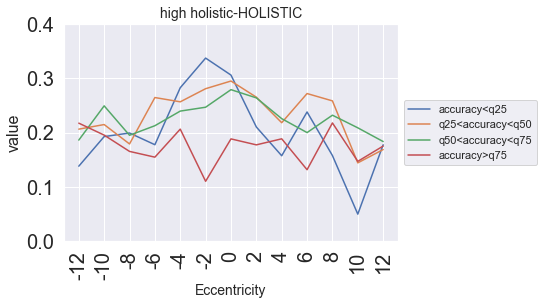

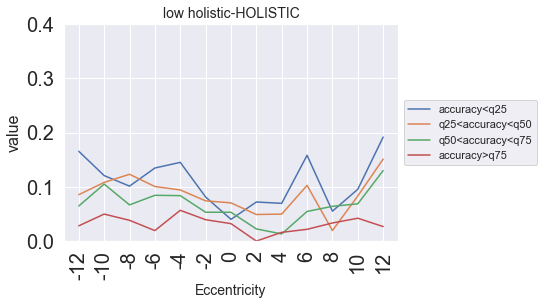

In [71]:
for holistic in ['high holistic', 'low holistic']:
    if holistic == 'high holistic':
        df = perMooney_means_highholistic_quartiles.copy()
    elif holistic == 'low holistic':
        df = perMooney_means_lowholistic_quartiles.copy()
        
    tmp = df.pivot_table(values='ACCURACY', index=['ECCLOC', 'MOONEY_NAME'], columns=['QUARTILE_COND']).reset_index() 
    tmp_grouped = tmp.groupby('ECCLOC', as_index=False).mean()

    tmp_grouped['1.0holistic'] = tmp_grouped['1.0upright'] - tmp_grouped['1.0inverted']
    tmp_grouped['2.0holistic'] = tmp_grouped['2.0upright'] - tmp_grouped['2.0inverted']
    tmp_grouped['3.0holistic'] = tmp_grouped['3.0upright'] - tmp_grouped['3.0inverted']
    tmp_grouped['4.0holistic'] = tmp_grouped['4.0upright'] - tmp_grouped['4.0inverted']
    
    tmp_grouped_plot = pd.melt(tmp_grouped, id_vars='ECCLOC', value_vars=['1.0holistic','2.0holistic', '3.0holistic', '4.0holistic'])
    ax = sns.lineplot(x='ECCLOC',y= 'value', hue = 'QUARTILE_COND', data= tmp_grouped_plot)
#     handles, l = ax.get_legend_handles_labels()
    ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks( range(-12, 14, 2), labels=labels, rotation=90); 
    plt.ylim(0, 0.4)
    plt.title(holistic + '-HOLISTIC', fontsize=14)
    # plt.yticks(np.arange(0.3, 1.1, 0.1))
    plt.xlabel('Eccentricity', fontsize=14)
    plt.show()

In [72]:
tmp = perMooney_means_lowholistic_quartiles.pivot_table(values='ACCURACY', index=['ECCLOC', 'MOONEY_NAME'], columns=['QUARTILE_COND']).reset_index() 
tmp#.merge(perMooney_means_lowholistic_quartiles['QUARTILE'], how='left', on='MOONEY_NAME')

QUARTILE_COND,ECCLOC,MOONEY_NAME,1.0inverted,1.0upright,2.0inverted,2.0upright,3.0inverted,3.0upright,4.0inverted,4.0upright
0,-12,U0006.bmp,0.680000,NaN,NaN,NaN,NaN,NaN,NaN,0.930233
1,-12,U0014.bmp,NaN,NaN,NaN,NaN,NaN,NaN,0.894737,0.918919
2,-12,U0020.bmp,NaN,0.794118,NaN,NaN,NaN,NaN,0.928571,NaN
3,-12,U0061.bmp,NaN,0.794118,NaN,NaN,0.846154,NaN,NaN,NaN
4,-12,U0076.bmp,0.571429,0.807692,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
255,12,U0335.bmp,NaN,NaN,NaN,NaN,0.791667,0.931034,NaN,NaN
256,12,U0346.bmp,NaN,0.731707,NaN,NaN,0.764706,NaN,NaN,NaN
257,12,U0359.bmp,NaN,0.808511,0.756757,NaN,NaN,NaN,NaN,NaN
258,12,U0361.bmp,0.645161,NaN,NaN,0.911765,NaN,NaN,NaN,NaN


In [73]:
tmp_grouped = tmp.groupby('ECCLOC', as_index=False).mean()
tmp_grouped

QUARTILE_COND,ECCLOC,1.0inverted,1.0upright,2.0inverted,2.0upright,3.0inverted,3.0upright,4.0inverted,4.0upright
0,-12,0.629448,0.795195,0.763159,0.849170,0.836972,0.902158,0.908304,0.937020
1,-10,0.644897,0.766017,0.760635,0.869191,0.804811,0.910265,0.905854,0.956133
2,-8,0.694010,0.795749,0.771987,0.895511,0.859327,0.926543,0.920320,0.959196
3,-6,0.669851,0.804910,0.798769,0.899744,0.853021,0.937857,0.939241,0.959168
4,-4,0.688303,0.833730,0.800152,0.894833,0.840027,0.924272,0.903933,0.961153
5,-2,0.758715,0.840470,0.827838,0.902512,0.873404,0.927083,0.935518,0.975474
6,0,0.802982,0.843590,0.830282,0.901214,0.878588,0.932245,0.942719,0.975458
7,2,0.714776,0.787279,0.841791,0.891312,0.915207,0.938213,0.963315,0.963930
8,4,0.726061,0.796171,0.837955,0.888238,0.907302,0.921117,0.943216,0.959930
9,6,0.664655,0.823071,0.791534,0.894631,0.863212,0.918332,0.919930,0.942197


In [74]:
tmp_grouped['1.0holistic'] = tmp_grouped['1.0upright'] - tmp_grouped['1.0inverted']

In [75]:
tmp_grouped['2.0holistic'] = tmp_grouped['2.0upright'] - tmp_grouped['2.0inverted']

In [76]:
tmp_grouped['3.0holistic'] = tmp_grouped['3.0upright'] - tmp_grouped['3.0inverted']

In [77]:
tmp_grouped['4.0holistic'] = tmp_grouped['4.0upright'] - tmp_grouped['4.0inverted']

<AxesSubplot:xlabel='ECCLOC', ylabel='1.0holistic'>

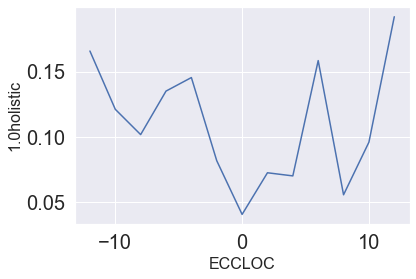

In [78]:
sns.lineplot(x='ECCLOC', y='1.0holistic', data = tmp_grouped, ci=False)

In [79]:
tmp_grouped_plot = pd.melt(tmp_grouped, id_vars='ECCLOC', value_vars=['1.0holistic','2.0holistic', '3.0holistic', '4.0holistic'])

<ipython-input-80-2e0ccff3ddd4>:3: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(handles[::-1], labels=l[::-1],loc='center left', bbox_to_anchor=(1, 0.5))


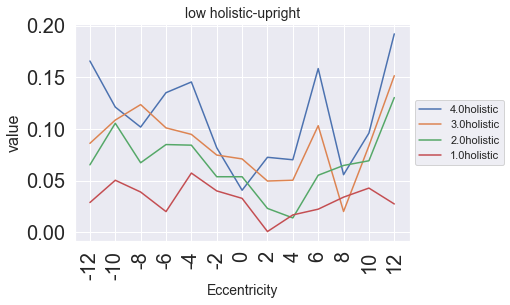

In [80]:
ax = sns.lineplot(x='ECCLOC',y= 'value', hue = 'QUARTILE_COND', data= tmp_grouped_plot)
handles, l = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels=l[::-1],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks( range(-12, 14, 2), labels=labels, rotation=90); 
# plt.ylim(0.4, 1.1)
plt.title(holistic + '-' + orientation, fontsize=14)
# plt.yticks(np.arange(0.3, 1.1, 0.1))
plt.xlabel('Eccentricity', fontsize=14)
plt.show()

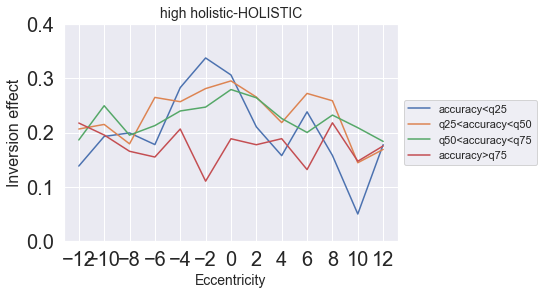

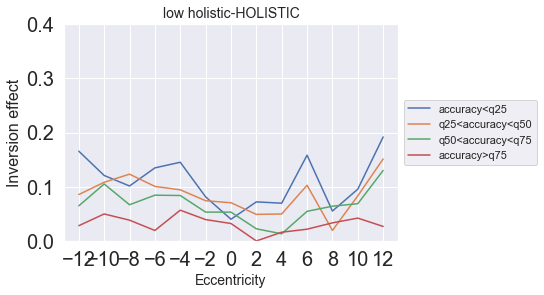

In [81]:

for holistic in ['high holistic', 'low holistic']:
    if holistic == 'high holistic':
        df = perMooney_means_highholistic_quartiles.copy()
    elif holistic == 'low holistic':
        df = perMooney_means_lowholistic_quartiles.copy()
        
    tmp = df.pivot_table(values='ACCURACY', index=['ECCLOC', 'MOONEY_NAME'], columns=['QUARTILE_COND']).reset_index() 
    tmp_grouped = tmp.groupby('ECCLOC', as_index=False).mean()

    tmp_grouped['1.0holistic'] = tmp_grouped['1.0upright'] - tmp_grouped['1.0inverted']
    tmp_grouped['2.0holistic'] = tmp_grouped['2.0upright'] - tmp_grouped['2.0inverted']
    tmp_grouped['3.0holistic'] = tmp_grouped['3.0upright'] - tmp_grouped['3.0inverted']
    tmp_grouped['4.0holistic'] = tmp_grouped['4.0upright'] - tmp_grouped['4.0inverted']
    
    tmp_grouped_plot = pd.melt(tmp_grouped, id_vars='ECCLOC', value_vars=['1.0holistic','2.0holistic', '3.0holistic', '4.0holistic'])
    ax = sns.lineplot(x='ECCLOC',y= 'value', hue = 'QUARTILE_COND', data= tmp_grouped_plot)
#     handles, l = ax.get_legend_handles_labels()
    ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks( range(-12, 14, 2))
    plt.ylabel('Inversion effect')
    plt.ylim(0, 0.4)
    plt.title(holistic + '-HOLISTIC', fontsize=14)
    # plt.yticks(np.arange(0.3, 1.1, 0.1))
    plt.xlabel('Eccentricity', fontsize=14)
    plt.show()
    
    if holistic == 'high holistic':
        highholistic_quartiles = tmp_grouped_plot
    elif holistic == 'low holistic':
        lowholistic_quartiles = tmp_grouped_plot


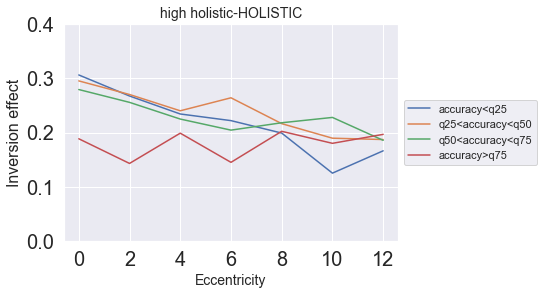

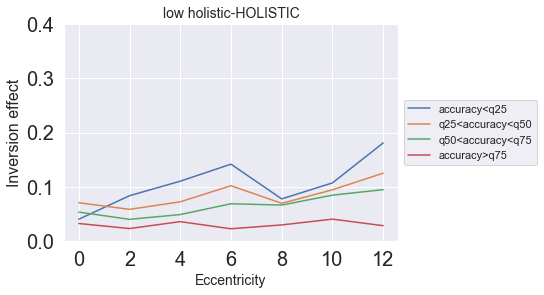

In [82]:

for holistic in ['high holistic', 'low holistic']:
    if holistic == 'high holistic':
        df = perMooney_means_highholistic_quartiles.copy()
    elif holistic == 'low holistic':
        df = perMooney_means_lowholistic_quartiles.copy()
        
    tmp = df.pivot_table(values='ACCURACY', index=['ECCENTRICITY', 'MOONEY_NAME'], columns=['QUARTILE_COND']).reset_index() 
    tmp_grouped = tmp.groupby('ECCENTRICITY', as_index=False).mean()

    tmp_grouped['1.0holistic'] = tmp_grouped['1.0upright'] - tmp_grouped['1.0inverted']
    tmp_grouped['2.0holistic'] = tmp_grouped['2.0upright'] - tmp_grouped['2.0inverted']
    tmp_grouped['3.0holistic'] = tmp_grouped['3.0upright'] - tmp_grouped['3.0inverted']
    tmp_grouped['4.0holistic'] = tmp_grouped['4.0upright'] - tmp_grouped['4.0inverted']
    
    tmp_grouped_plot = pd.melt(tmp_grouped, id_vars='ECCENTRICITY', value_vars=['1.0holistic','2.0holistic', '3.0holistic', '4.0holistic'])
    ax = sns.lineplot(x='ECCENTRICITY',y= 'value', hue = 'QUARTILE_COND', data= tmp_grouped_plot)
#     handles, l = ax.get_legend_handles_labels()
    ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks( range(0, 14, 2))
    plt.ylabel('Inversion effect')
    plt.ylim(0, 0.4)
    plt.title(holistic + '-HOLISTIC', fontsize=14)
    # plt.yticks(np.arange(0.3, 1.1, 0.1))
    plt.xlabel('Eccentricity', fontsize=14)
    plt.show()
    
    if holistic == 'high holistic':
        highholistic_quartiles_abs = tmp_grouped_plot
    elif holistic == 'low holistic':
        lowholistic_quartiles_abs = tmp_grouped_plot


### Difference 

In [83]:
highholistic_quartiles['MOONEY_CATEGORY'] = 'high holistic'
lowholistic_quartiles['MOONEY_CATEGORY'] = 'low holistic'

holistic_quartiles = pd.concat([lowholistic_quartiles, highholistic_quartiles])

In [85]:
diff_df = pd.DataFrame()

for q in holistic_quartiles.QUARTILE_COND.unique():
    diff_df_q = pd.DataFrame()
    tmp = holistic_quartiles.loc[holistic_quartiles['QUARTILE_COND'] == q].sort_values(by='ECCLOC').reset_index(drop=True)
    high = tmp[tmp['MOONEY_CATEGORY'] == 'high holistic'].sort_values('ECCLOC').reset_index(drop=True)
    low = tmp[tmp['MOONEY_CATEGORY'] == 'low holistic'].sort_values('ECCLOC').reset_index(drop=True)
    
    diff_df_q['ECCLOC'] = high['ECCLOC'].copy()
    diff_df_q['EMPIRICAL'] = high['value'] - low['value']
    diff_df_q['QUARTILE'] = q
    
    for iteration in range(5000):
        permuted = tmp['MOONEY_CATEGORY'].sample(n=len(tmp)).reset_index(drop=True)
        tmp['MOONEY_CATEGORY_PERMUTED'] = permuted
        
        high_permuted = tmp[tmp['MOONEY_CATEGORY_PERMUTED'] == 'high holistic'].sort_values('ECCLOC').reset_index(drop=True)
        low_permuted = tmp[tmp['MOONEY_CATEGORY_PERMUTED'] == 'low holistic'].sort_values('ECCLOC').reset_index(drop=True)
        diff_df_q['ITERATION'+str(iteration)] = high_permuted['value'] - low_permuted['value']
        
    diff_df = pd.concat([diff_df, diff_df_q])
    
diff_df.reset_index(drop=True, inplace=True)

In [86]:
for row in range(len(diff_df)):
    diff_df.loc[row, 'P97'] = sorted(diff_df.loc[row, 'ITERATION0':'ITERATION4999'])[int(5000*0.97)]

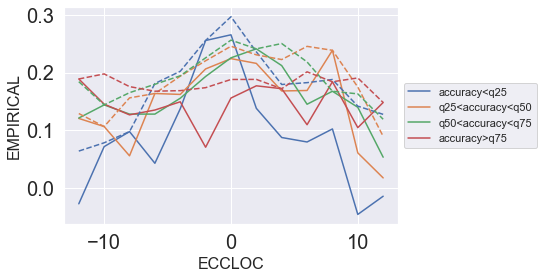

In [87]:
ax = sns.lineplot(x='ECCLOC', y='EMPIRICAL', data=diff_df, hue='QUARTILE', linestyle='-')
ax = sns.lineplot(x='ECCLOC', y='P97', data=diff_df, hue='QUARTILE', linestyle='--')
ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'], loc='center left', bbox_to_anchor=(1, 0.5))


In [88]:
highholistic_quartiles_abs['MOONEY_CATEGORY'] = 'high holistic'
lowholistic_quartiles_abs['MOONEY_CATEGORY'] = 'low holistic'

holistic_quartiles_abs = pd.concat([lowholistic_quartiles_abs, highholistic_quartiles_abs])

diff_df_abs = pd.DataFrame()

for q in holistic_quartiles_abs.QUARTILE_COND.unique():
    diff_df_abs_q = pd.DataFrame()
    tmp = holistic_quartiles_abs.loc[holistic_quartiles_abs['QUARTILE_COND'] == q].sort_values(by='ECCENTRICITY').reset_index(drop=True)
    high = tmp[tmp['MOONEY_CATEGORY'] == 'high holistic'].sort_values('ECCENTRICITY').reset_index(drop=True)
    low = tmp[tmp['MOONEY_CATEGORY'] == 'low holistic'].sort_values('ECCENTRICITY').reset_index(drop=True)
    
    diff_df_abs_q['ECCENTRICITY'] = high['ECCENTRICITY'].copy()
    diff_df_abs_q['EMPIRICAL'] = high['value'] - low['value']
    diff_df_abs_q['QUARTILE'] = q
    
    for iteration in range(5000):
        permuted = tmp['MOONEY_CATEGORY'].sample(n=len(tmp)).reset_index(drop=True)
        tmp['MOONEY_CATEGORY_PERMUTED'] = permuted
        
        high_permuted = tmp[tmp['MOONEY_CATEGORY_PERMUTED'] == 'high holistic'].sort_values('ECCENTRICITY').reset_index(drop=True)
        low_permuted = tmp[tmp['MOONEY_CATEGORY_PERMUTED'] == 'low holistic'].sort_values('ECCENTRICITY').reset_index(drop=True)
        diff_df_abs_q['ITERATION'+str(iteration)] = high_permuted['value'] - low_permuted['value']
        
    diff_df_abs = pd.concat([diff_df_abs, diff_df_abs_q])
    
diff_df_abs.reset_index(drop=True, inplace=True)

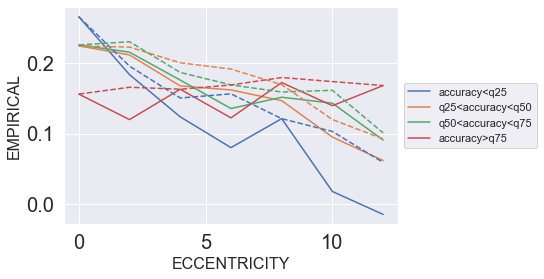

In [89]:
for row in range(len(diff_df_abs)):
    diff_df_abs.loc[row, 'P97'] = sorted(diff_df_abs.loc[row, 'ITERATION0':'ITERATION4999'])[int(5000*0.97)]
    
ax = sns.lineplot(x='ECCENTRICITY', y='EMPIRICAL', data=diff_df_abs, hue='QUARTILE', linestyle='-')
ax = sns.lineplot(x='ECCENTRICITY', y='P97', data=diff_df_abs, hue='QUARTILE', linestyle='--')
ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'], loc='center left', bbox_to_anchor=(1, 0.5))


## Per subject 

### Upright vs. inverted

In [94]:
perMooney_means_sub = allsubjects.groupby(['SUBINIT', 'MOONEY_NAME', 'ECCENTRICITY', 'LOC', 'COND', 'MOONEYCATEGORY'], as_index=False)['ACCURACY'].mean()


<ipython-input-122-8af78dabe88e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perMooney_means_sub_holistic['ECCLOC'] = perMooney_means_sub_holistic['ECCENTRICITY'].copy()
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


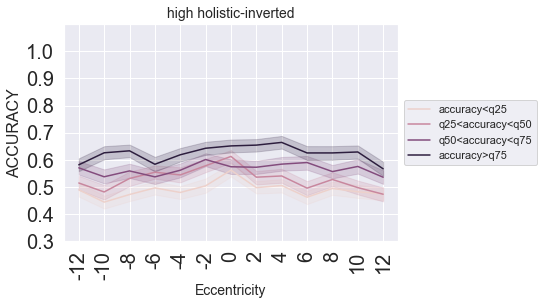

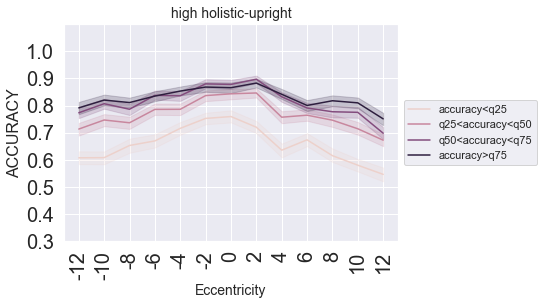

<ipython-input-122-8af78dabe88e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perMooney_means_sub_holistic['ECCLOC'] = perMooney_means_sub_holistic['ECCENTRICITY'].copy()
/Users/teresa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


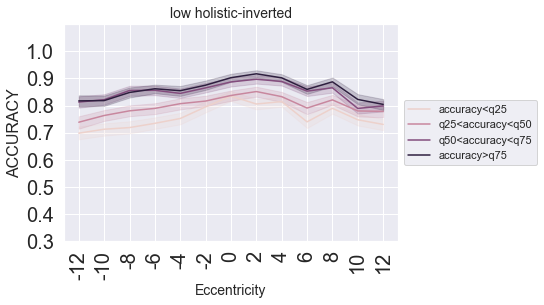

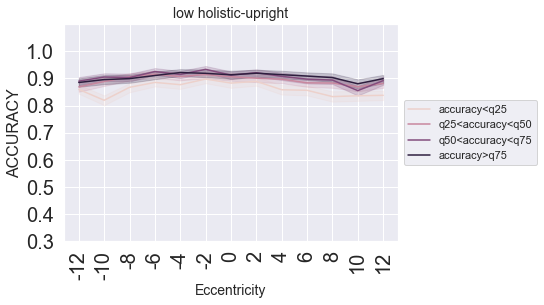

In [122]:
for holistic in perMooney_means_sub.MOONEYCATEGORY.unique():
    
    perMooney_means_sub_holistic = perMooney_means_sub[perMooney_means_sub['MOONEYCATEGORY'] == holistic]

    perMooney_means_sub_holistic['ECCLOC'] = perMooney_means_sub_holistic['ECCENTRICITY'].copy()
    perMooney_means_sub_holistic.loc[perMooney_means_sub_holistic['LOC'] == 'left', 'ECCLOC'] = -perMooney_means_sub_holistic.loc[perMooney_means_sub_holistic['LOC'] == 'left', 'ECCENTRICITY']
    
    for orientation in perMooney_means_sub_holistic.COND.unique():
        perMooney_means_sub_holistic_orientation = perMooney_means_sub_holistic[perMooney_means_sub_holistic['COND'] == orientation]

        labels=[]
        for i in range(-12, 14, 2):
            labels.append(str(i))

#         def percentile(n):
#             def percentile_(x):
#                 return np.percentile(x, n)
#             percentile_.__name__ = 'percentile_%s' % n
#             return percentile_
        
#         perMooney_means_sub_holistic_quartiles = pd.DataFrame()
#         for sub in perMooney_means_sub_holistic_orientation.SUBINIT.unique():
#             tmp2 = perMooney_means_sub_holistic_orientation[perMooney_means_sub_holistic_orientation['SUBINIT'] == sub]
#             quartiles_holistic = (tmp2.groupby(["ECCLOC"]).agg(q25= ('ACCURACY',percentile(25)), q50= ('ACCURACY',percentile(50)), q75= ('ACCURACY',percentile(75))))
            
#     #         quartiles_holistic

#             tmp = pd.merge(tmp2, quartiles_holistic, how='left', on='ECCLOC')
#             tmp.loc[tmp['ACCURACY'] <= tmp['q25'],'QUARTILE'] = 1
#             tmp.loc[(tmp['ACCURACY'] > tmp['q25']) & (tmp['ACCURACY'] <= tmp['q50']),'QUARTILE'] = 2
#             tmp.loc[(tmp['ACCURACY'] > tmp['q50']) & (tmp['ACCURACY'] <= tmp['q75']),'QUARTILE'] = 3
#             tmp.loc[tmp['ACCURACY'] > tmp['q75'],'QUARTILE'] = 4
#             perMooney_means_sub_holistic_quartiles = pd.concat([perMooney_means_sub_holistic_quartiles, tmp])


    
        if (orientation == 'upright') & (holistic == 'high holistic'):
            perMooney_means_sub_holistic_quartiles = pd.merge(perMooney_means_sub_holistic_orientation, perMooney_means_highholistic_quartiles_upright[['MOONEY_NAME', 'QUARTILE']], how='left', on='MOONEY_NAME')
            perMooney_means_sub_highholistic_quartiles_upright = perMooney_means_sub_holistic_quartiles.copy()
#             perMooney_means_sub_highholistic_quartiles_upright = perMooney_means_sub_holistic_quartiles
        elif (orientation == 'inverted') & (holistic == 'high holistic'):
            perMooney_means_sub_holistic_quartiles = pd.merge(perMooney_means_sub_holistic_orientation, perMooney_means_highholistic_quartiles_inverted[['MOONEY_NAME', 'QUARTILE']], how='left', on='MOONEY_NAME')
            perMooney_means_sub_highholistic_quartiles_inverted = perMooney_means_sub_holistic_quartiles.copy()
#             perMooney_means_sub_highholistic_quartiles_inverted = perMooney_means_sub_holistic_quartiles
        elif (orientation == 'upright') & (holistic == 'low holistic'):
            perMooney_means_sub_holistic_quartiles = pd.merge(perMooney_means_sub_holistic_orientation, perMooney_means_lowholistic_quartiles_upright[['MOONEY_NAME', 'QUARTILE']], how='left', on='MOONEY_NAME')
            perMooney_means_sub_lowholistic_quartiles_upright = perMooney_means_sub_holistic_quartiles.copy()
#             perMooney_means_sub_lowholistic_quartiles_upright = perMooney_means_sub_holistic_quartiles
        elif (orientation == 'inverted') & (holistic == 'low holistic'):
            perMooney_means_sub_holistic_quartiles = pd.merge(perMooney_means_sub_holistic_orientation, perMooney_means_lowholistic_quartiles_inverted[['MOONEY_NAME', 'QUARTILE']], how='left', on='MOONEY_NAME')
            
            perMooney_means_sub_lowholistic_quartiles_inverted = perMooney_means_sub_holistic_quartiles.copy()
            
        ax = sns.lineplot(x = 'ECCLOC', y='ACCURACY', hue='QUARTILE', data=perMooney_means_sub_holistic_quartiles)
        handles, l = ax.get_legend_handles_labels()
#         ax.legend(handles[::-1], labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'],loc='center left', bbox_to_anchor=(1, 0.5))
        ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xticks( range(-12, 14, 2), labels=labels, rotation=90); 
        plt.ylim(0.4, 1.1)
        plt.title(holistic + '-' + orientation, fontsize=14)
        plt.yticks(np.arange(0.3, 1.1, 0.1))
        plt.xlabel('Eccentricity', fontsize=14)
        plt.show()

### Holistic 

In [123]:
perMooney_means_sub_lowholistic_quartiles = pd.concat([perMooney_means_sub_lowholistic_quartiles_upright,perMooney_means_sub_lowholistic_quartiles_inverted])
perMooney_means_sub_highholistic_quartiles = pd.concat([perMooney_means_sub_highholistic_quartiles_upright,perMooney_means_sub_highholistic_quartiles_inverted])
perMooney_means_sub_lowholistic_quartiles['QUARTILE_COND'] = perMooney_means_sub_lowholistic_quartiles['QUARTILE'].astype('str') + perMooney_means_sub_lowholistic_quartiles['COND']
perMooney_means_sub_highholistic_quartiles['QUARTILE_COND'] = perMooney_means_sub_highholistic_quartiles['QUARTILE'].astype('str') + perMooney_means_sub_highholistic_quartiles['COND']

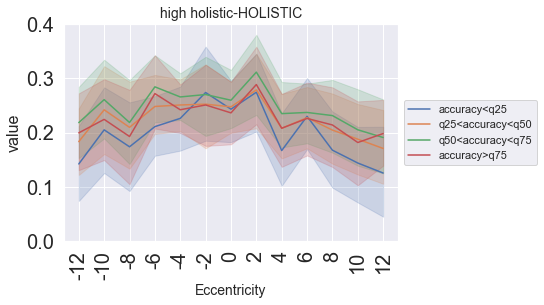

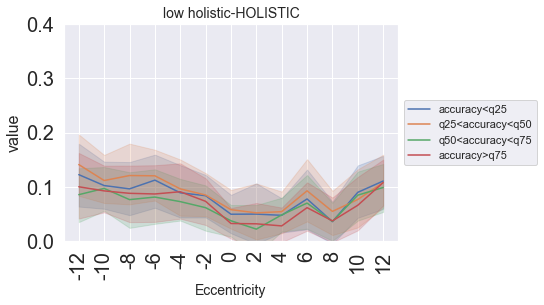

In [148]:
for holistic in ['high holistic', 'low holistic']:
    if holistic == 'high holistic':
        df = perMooney_means_sub_highholistic_quartiles.copy()
    elif holistic == 'low holistic':
        df = perMooney_means_sub_lowholistic_quartiles.copy()
    
    labels=[]
    for i in range(-12, 14, 2):
        labels.append(str(i))
    tmp_sub = df.pivot_table(values='ACCURACY', index=['SUBINIT', 'ECCLOC', 'MOONEY_NAME'], columns=['QUARTILE_COND']).reset_index() 
    tmp_sub_grouped = tmp_sub.groupby(['SUBINIT','ECCLOC'], as_index=False).mean()

    tmp_sub_grouped['1.0holistic'] = tmp_sub_grouped['1.0upright'] - tmp_sub_grouped['1.0inverted']
    tmp_sub_grouped['2.0holistic'] = tmp_sub_grouped['2.0upright'] - tmp_sub_grouped['2.0inverted']
    tmp_sub_grouped['3.0holistic'] = tmp_sub_grouped['3.0upright'] - tmp_sub_grouped['3.0inverted']
    tmp_sub_grouped['4.0holistic'] = tmp_sub_grouped['4.0upright'] - tmp_sub_grouped['4.0inverted']
    
    tmp_sub_grouped_plot = pd.melt(tmp_sub_grouped, id_vars=['SUBINIT','ECCLOC'], value_vars=['1.0holistic','2.0holistic', '3.0holistic', '4.0holistic'])
    ax = sns.lineplot(x='ECCLOC',y= 'value', hue = 'QUARTILE_COND', data= tmp_sub_grouped_plot)
    ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks( range(-12, 14, 2), labels=labels, rotation=90); 
    plt.ylim(0, 0.4)
    plt.title(holistic + '-HOLISTIC', fontsize=14)
    # plt.yticks(np.arange(0.3, 1.1, 0.1))
    plt.xlabel('Eccentricity', fontsize=14)
    plt.show()
    
    if holistic == 'high holistic':
        highholistic_quartiles_sub = tmp_sub_grouped_plot
    elif holistic == 'low holistic':
        lowholistic_quartiles_sub = tmp_sub_grouped_plot

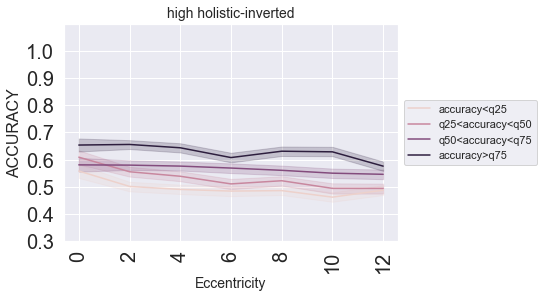

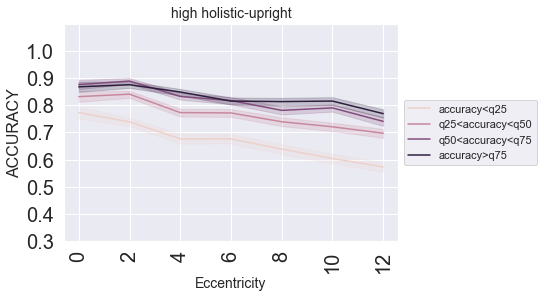

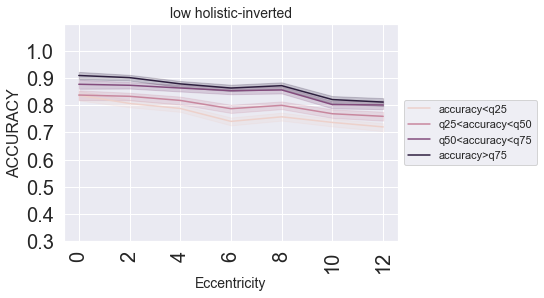

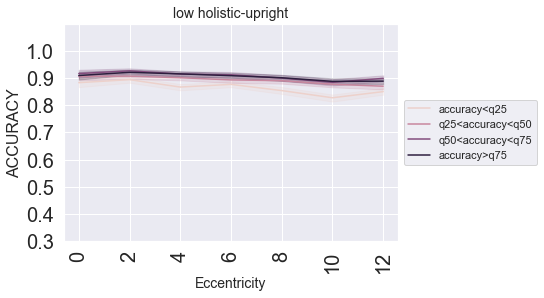

In [134]:
for holistic in perMooney_means_sub.MOONEYCATEGORY.unique():
    
    perMooney_means_sub_holistic = perMooney_means_sub[perMooney_means_sub['MOONEYCATEGORY'] == holistic]


    for orientation in perMooney_means_sub_holistic.COND.unique():
        perMooney_means_sub_holistic_orientation = perMooney_means_sub_holistic[perMooney_means_sub_holistic['COND'] == orientation]

        labels=[]
        for i in range(0, 14, 2):
            labels.append(str(i))
    
        if (orientation == 'upright') & (holistic == 'high holistic'):
            perMooney_means_sub_holistic_quartiles = pd.merge(perMooney_means_sub_holistic_orientation, perMooney_means_highholistic_quartiles_upright_abs[['MOONEY_NAME', 'QUARTILE']], how='left', on='MOONEY_NAME')
            perMooney_means_sub_highholistic_quartiles_upright_abs = perMooney_means_sub_holistic_quartiles.copy()
#             perMooney_means_sub_highholistic_quartiles_upright = perMooney_means_sub_holistic_quartiles
        elif (orientation == 'inverted') & (holistic == 'high holistic'):
            perMooney_means_sub_holistic_quartiles = pd.merge(perMooney_means_sub_holistic_orientation, perMooney_means_highholistic_quartiles_inverted_abs[['MOONEY_NAME', 'QUARTILE']], how='left', on='MOONEY_NAME')
            perMooney_means_sub_highholistic_quartiles_inverted_abs = perMooney_means_sub_holistic_quartiles.copy()
#             perMooney_means_sub_highholistic_quartiles_inverted = perMooney_means_sub_holistic_quartiles
        elif (orientation == 'upright') & (holistic == 'low holistic'):
            perMooney_means_sub_holistic_quartiles = pd.merge(perMooney_means_sub_holistic_orientation, perMooney_means_lowholistic_quartiles_upright_abs[['MOONEY_NAME', 'QUARTILE']], how='left', on='MOONEY_NAME')
            perMooney_means_sub_lowholistic_quartiles_upright_abs = perMooney_means_sub_holistic_quartiles.copy()
#             perMooney_means_sub_lowholistic_quartiles_upright = perMooney_means_sub_holistic_quartiles
        elif (orientation == 'inverted') & (holistic == 'low holistic'):
            perMooney_means_sub_holistic_quartiles = pd.merge(perMooney_means_sub_holistic_orientation, perMooney_means_lowholistic_quartiles_inverted_abs[['MOONEY_NAME', 'QUARTILE']], how='left', on='MOONEY_NAME')
            
            perMooney_means_sub_lowholistic_quartiles_inverted_abs = perMooney_means_sub_holistic_quartiles.copy()
            
        ax = sns.lineplot(x = 'ECCENTRICITY', y='ACCURACY', hue='QUARTILE', data=perMooney_means_sub_holistic_quartiles)
        handles, l = ax.get_legend_handles_labels()
#         ax.legend(handles[::-1], labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'],loc='center left', bbox_to_anchor=(1, 0.5))
        ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xticks( range(0, 14, 2), labels=labels, rotation=90); 
        plt.ylim(0.4, 1.1)
        plt.title(holistic + '-' + orientation, fontsize=14)
        plt.yticks(np.arange(0.3, 1.1, 0.1))
        plt.xlabel('Eccentricity', fontsize=14)
        plt.show()
        


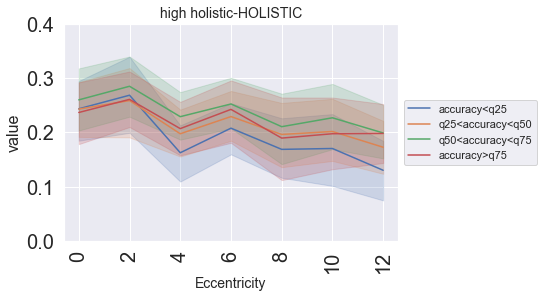

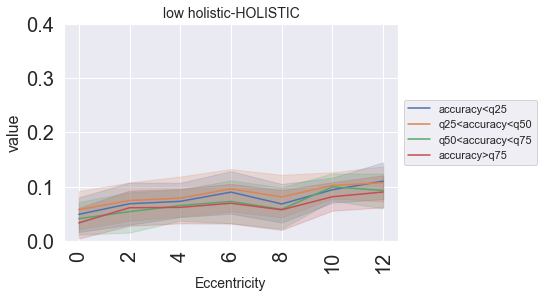

In [144]:
perMooney_means_sub_lowholistic_quartiles_abs = pd.concat([perMooney_means_sub_lowholistic_quartiles_upright_abs,perMooney_means_sub_lowholistic_quartiles_inverted_abs])
perMooney_means_sub_highholistic_quartiles_abs = pd.concat([perMooney_means_sub_highholistic_quartiles_upright_abs,perMooney_means_sub_highholistic_quartiles_inverted_abs])
perMooney_means_sub_lowholistic_quartiles_abs['QUARTILE_COND'] = perMooney_means_sub_lowholistic_quartiles_abs['QUARTILE'].astype('str') + perMooney_means_sub_lowholistic_quartiles_abs['COND']
perMooney_means_sub_highholistic_quartiles_abs['QUARTILE_COND'] = perMooney_means_sub_highholistic_quartiles_abs['QUARTILE'].astype('str') + perMooney_means_sub_highholistic_quartiles_abs['COND']


for holistic in ['high holistic', 'low holistic']:
    if holistic == 'high holistic':
        df = perMooney_means_sub_highholistic_quartiles_abs.copy()
    elif holistic == 'low holistic':
        df = perMooney_means_sub_lowholistic_quartiles_abs.copy()
    
    labels=[]
    for i in range(0, 14, 2):
        labels.append(str(i))
    tmp_sub = df.pivot_table(values='ACCURACY', index=['SUBINIT', 'ECCENTRICITY', 'MOONEY_NAME'], columns=['QUARTILE_COND']).reset_index() 
    tmp_sub_grouped = tmp_sub.groupby(['SUBINIT','ECCENTRICITY'], as_index=False).mean()

    tmp_sub_grouped['1.0holistic'] = tmp_sub_grouped['1.0upright'] - tmp_sub_grouped['1.0inverted']
    tmp_sub_grouped['2.0holistic'] = tmp_sub_grouped['2.0upright'] - tmp_sub_grouped['2.0inverted']
    tmp_sub_grouped['3.0holistic'] = tmp_sub_grouped['3.0upright'] - tmp_sub_grouped['3.0inverted']
    tmp_sub_grouped['4.0holistic'] = tmp_sub_grouped['4.0upright'] - tmp_sub_grouped['4.0inverted']
    
    tmp_sub_grouped_plot = pd.melt(tmp_sub_grouped, id_vars=['SUBINIT','ECCENTRICITY'], value_vars=['1.0holistic','2.0holistic', '3.0holistic', '4.0holistic'])
    ax = sns.lineplot(x='ECCENTRICITY',y= 'value', hue = 'QUARTILE_COND', data= tmp_sub_grouped_plot)
    ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks( range(0, 14, 2), labels=labels, rotation=90); 
    plt.ylim(0, 0.4)
    plt.title(holistic + '-HOLISTIC', fontsize=14)
    # plt.yticks(np.arange(0.3, 1.1, 0.1))
    plt.xlabel('Eccentricity', fontsize=14)
    plt.show()
    
    if holistic == 'high holistic':
        highholistic_quartiles_sub_abs = tmp_sub_grouped_plot
    elif holistic == 'low holistic':
        lowholistic_quartiles_sub_abs = tmp_sub_grouped_plot

### Difference 

In [150]:
highholistic_quartiles_sub['MOONEY_CATEGORY'] = 'high holistic'
lowholistic_quartiles_sub['MOONEY_CATEGORY'] = 'low holistic'

holistic_quartiles_sub = pd.concat([lowholistic_quartiles_sub, highholistic_quartiles_sub])

In [153]:
new = 0
if new:
    diff_df_sub = pd.DataFrame()

    for subject in holistic_quartiles_sub.SUBINIT.unique():
        for q in holistic_quartiles_sub.QUARTILE_COND.unique():
            diff_df_sub_q = pd.DataFrame()
            tmp = holistic_quartiles_sub.loc[(holistic_quartiles_sub['QUARTILE_COND'] == q) & (holistic_quartiles_sub['SUBINIT'] == subject)].sort_values(by=['SUBINIT','ECCLOC']).reset_index(drop=True)
            high = tmp[tmp['MOONEY_CATEGORY'] == 'high holistic'].sort_values(by=['SUBINIT','ECCLOC']).reset_index(drop=True)
            low = tmp[tmp['MOONEY_CATEGORY'] == 'low holistic'].sort_values(by=['SUBINIT','ECCLOC']).reset_index(drop=True)

            diff_df_sub_q['ECCLOC'] = high['ECCLOC'].copy()
            diff_df_sub_q['EMPIRICAL'] = high['value'] - low['value']
            diff_df_sub_q['QUARTILE'] = q
            diff_df_sub_q['SUBINIT'] = subject

            for iteration in range(5000):
                permuted = tmp['MOONEY_CATEGORY'].sample(n=len(tmp)).reset_index(drop=True)
                tmp['MOONEY_CATEGORY_PERMUTED'] = permuted

                high_permuted = tmp[tmp['MOONEY_CATEGORY_PERMUTED'] == 'high holistic'].sort_values(by=['SUBINIT','ECCLOC']).reset_index(drop=True)
                low_permuted = tmp[tmp['MOONEY_CATEGORY_PERMUTED'] == 'low holistic'].sort_values(by=['SUBINIT','ECCLOC']).reset_index(drop=True)
                diff_df_sub_q['ITERATION'+str(iteration)] = high_permuted['value'] - low_permuted['value']

            diff_df_sub = pd.concat([diff_df_sub, diff_df_sub_q])

    diff_df_sub.reset_index(drop=True, inplace=True)
    diff_df_sub.to_csv('diff_df_sub.csv')
else:
    diff_df_sub = pd.read_csv('diff_df_sub.csv', index_col=0)

In [166]:
diff_df_sub_means = diff_df_sub.groupby(['ECCLOC', 'QUARTILE'], as_index=False).mean()
diff_df_sub_means.head()

,ECCLOC,QUARTILE,EMPIRICAL,ITERATION0,ITERATION1,ITERATION2,ITERATION3,ITERATION4,ITERATION5,ITERATION6,...,ITERATION4991,ITERATION4992,ITERATION4993,ITERATION4994,ITERATION4995,ITERATION4996,ITERATION4997,ITERATION4998,ITERATION4999,P97
0,-12,1.0holistic,0.019715,0.019833,0.107821,-0.001534,-0.032512,0.003661,-0.025692,-0.025150,...,-0.000678,-0.065818,0.053007,-0.042671,0.028637,0.018369,-0.025546,0.074630,-0.011889,0.333495
1,-12,2.0holistic,0.042238,-0.008645,0.012205,0.001467,-0.000918,0.014904,0.023665,0.032160,...,-0.024176,0.023533,-0.059288,0.048396,0.051636,0.029772,-0.082522,0.027382,-0.028226,0.304662
2,-12,3.0holistic,0.132566,0.058507,0.001857,-0.038604,0.029206,-0.001128,-0.107436,-0.087658,...,0.000100,-0.005383,0.014745,0.009131,-0.005738,-0.014866,-0.019564,0.041755,-0.024544,0.296670
3,-12,4.0holistic,0.099197,0.019899,-0.106187,-0.019727,-0.096104,-0.054862,-0.098265,0.037184,...,-0.027525,0.028399,0.005204,0.038014,0.043509,-0.043032,0.026829,-0.024346,-0.031849,0.314832
4,-10,1.0holistic,0.102492,0.065825,-0.038545,-0.003346,-0.074201,0.081686,0.033605,0.018764,...,-0.074509,0.067731,-0.033812,0.022774,-0.011595,0.105587,0.082553,-0.046469,-0.060494,0.368199


In [168]:
for row in range(len(diff_df_sub_means)):
    diff_df_sub_means.loc[row, 'P97'] = sorted(diff_df_sub_means.loc[row, 'ITERATION0':'ITERATION4999'])[int(5000*0.97)]

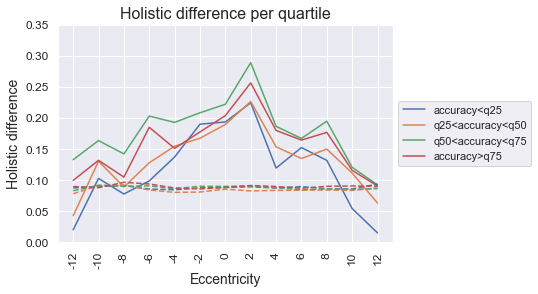

In [176]:
ax = sns.lineplot(x='ECCLOC', y='EMPIRICAL', data=diff_df_sub_means, hue='QUARTILE', linestyle='-')
ax = sns.lineplot(x='ECCLOC', y='P97', data=diff_df_sub_means, hue='QUARTILE', linestyle='--')
ax.legend(labels=['accuracy<q25', 'q25<accuracy<q50', 'q50<accuracy<q75', 'accuracy>q75'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Holistic difference per quartile', fontsize=16)
plt.ylabel('Holistic difference', fontsize=14)
plt.yticks(np.arange(0, 0.4, 0.05), fontsize=12)
plt.xlabel('Eccentricity', fontsize=14)
labels=[]
for i in range(-12, 14, 2):
    labels.append(str(i))
plt.xticks( range(-12, 14, 2), labels=labels, rotation=90, fontsize=12); 
